# **WiDS Dataset 2024 Overview**

- **Dataset Source:** Provided by Gilead Sciences through Health Verity, featuring patients diagnosed with metastatic triple negative breast cancer in the US.
  
- **Dataset Enrichment:**
  - Includes demographics (age, race, BMI), diagnosis details (cancer codes, treatment), and insurance information.
  - Geo-demographic data enriched from US Zip Codes Database for socio-economic insights.
  - Zip code level climate data added to explore climate's impact on healthcare access.
  
- **Target Column:** The dataset includes a target variable **metastatic_diagnosis_period**, which measures the period (in days) between the initial breast cancer diagnosis and the subsequent diagnosis of metastatic cancer.



In [ ]:
from google.colab import files
files.upload()

In [2]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c widsdatathon2024-challenge2

  0% 0.00/5.71M [00:00<?, ?B/s]
100% 5.71M/5.71M [00:00<00:00, 73.1MB/s]


In [4]:
!unzip widsdatathon2024-challenge2.zip
!ls

Archive:  widsdatathon2024-challenge2.zip
  inflating: solution_template.csv   
  inflating: test.csv                
  inflating: train.csv               
kaggle.json  solution_template.csv  train.csv
sample_data  test.csv		    widsdatathon2024-challenge2.zip


# **Loading the Libraries**

In [5]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
import math

# **Loading the datasets**

In [6]:
train= pd.read_csv('/content/train.csv')

train.head()

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,...,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
0,268700,NaN,COMMERCIAL,AR,724,South,West South Central,39,F,NaN,...,52.55,74.77,79.96,81.69,78.30,74.56,59.98,42.98,41.18,191
1,484983,White,NaN,IL,629,Midwest,East North Central,55,F,35.36,...,49.30,72.87,77.40,77.43,75.83,72.64,58.36,39.68,39.71,33
2,277055,NaN,COMMERCIAL,CA,925,West,Pacific,59,F,NaN,...,68.50,70.31,78.61,87.24,85.52,80.75,70.81,62.67,55.58,157
3,320055,Hispanic,MEDICAID,CA,900,West,Pacific,59,F,NaN,...,63.34,63.10,67.45,75.86,75.24,71.10,68.95,65.46,59.46,146
4,190386,NaN,COMMERCIAL,CA,934,West,Pacific,71,F,NaN,...,59.45,60.24,64.77,69.81,70.13,68.10,65.38,60.72,54.08,286


In [7]:
test = pd.read_csv('/content/test.csv')

test.head()

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,...,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18
0,730681,NaN,COMMERCIAL,LA,713,South,West South Central,55,F,NaN,...,62.21,62.23,78.34,81.96,83.58,82.22,80.20,69.73,53.14,51.34
1,334212,Black,NaN,NC,283,South,South Atlantic,60,F,40.00,...,48.63,58.14,77.26,80.05,82.88,82.09,78.85,64.60,50.57,48.10
2,571362,NaN,COMMERCIAL,TX,794,South,West South Central,54,F,32.33,...,57.82,59.95,77.79,82.45,82.44,80.77,72.16,59.31,48.25,42.13
3,907331,NaN,COMMERCIAL,TN,373,South,East South Central,63,F,27.07,...,47.57,53.50,71.31,75.20,76.96,75.78,74.87,61.06,44.31,42.83
4,208382,Asian,NaN,WA,980,West,Pacific,62,F,NaN,...,41.02,46.25,56.92,57.88,66.16,65.21,57.52,49.53,43.75,38.33


In [8]:
# Get the shape of the DataFrame
shape_train = train.shape

# Print the shape
print("Shape of train data:", shape_train)

Shape of train data: (13173, 152)


In [9]:
# Get the shape of the DataFrame
shape_test = test.shape

# Print the shape
print("Shape of test data:", shape_test)

Shape of test data: (5646, 151)


In [10]:
# Counting numerical columns
numerical_columns = train.select_dtypes(include=['int64', 'float64']).columns
num_numerical_columns = len(numerical_columns)

# Counting categorical columns
categorical_columns = train.select_dtypes(include=['object', 'category']).columns
num_categorical_columns = len(categorical_columns)

# Printing the counts
print("Number of numerical columns in train data:", num_numerical_columns)
print("Number of categorical columns in train data:", num_categorical_columns)


Number of numerical columns in train data: 141
Number of categorical columns in train data: 11


In [11]:
# Counting numerical columns
numerical_columns = test.select_dtypes(include=['int64', 'float64']).columns
num_numerical_columns = len(numerical_columns)

# Counting categorical columns
categorical_columns = test.select_dtypes(include=['object', 'category']).columns
num_categorical_columns = len(categorical_columns)

# Printing the counts
print("Number of numerical columns in test data:", num_numerical_columns)
print("Number of categorical columns in test data:", num_categorical_columns)

Number of numerical columns in test data: 140
Number of categorical columns in test data: 11


# **Identifying the Most Related Columns to the Target Variable**

In [12]:
# Selecting only numerical columns
numerical_columns = train.select_dtypes(include=['int64', 'float64'])

# Selecting only categorical columns
categorical_columns = train.select_dtypes(include=['object']).columns

# Specify the target variable
target_variable = 'metastatic_diagnosis_period'

# Calculate the correlation matrix
corr_matrix = numerical_columns.corr()

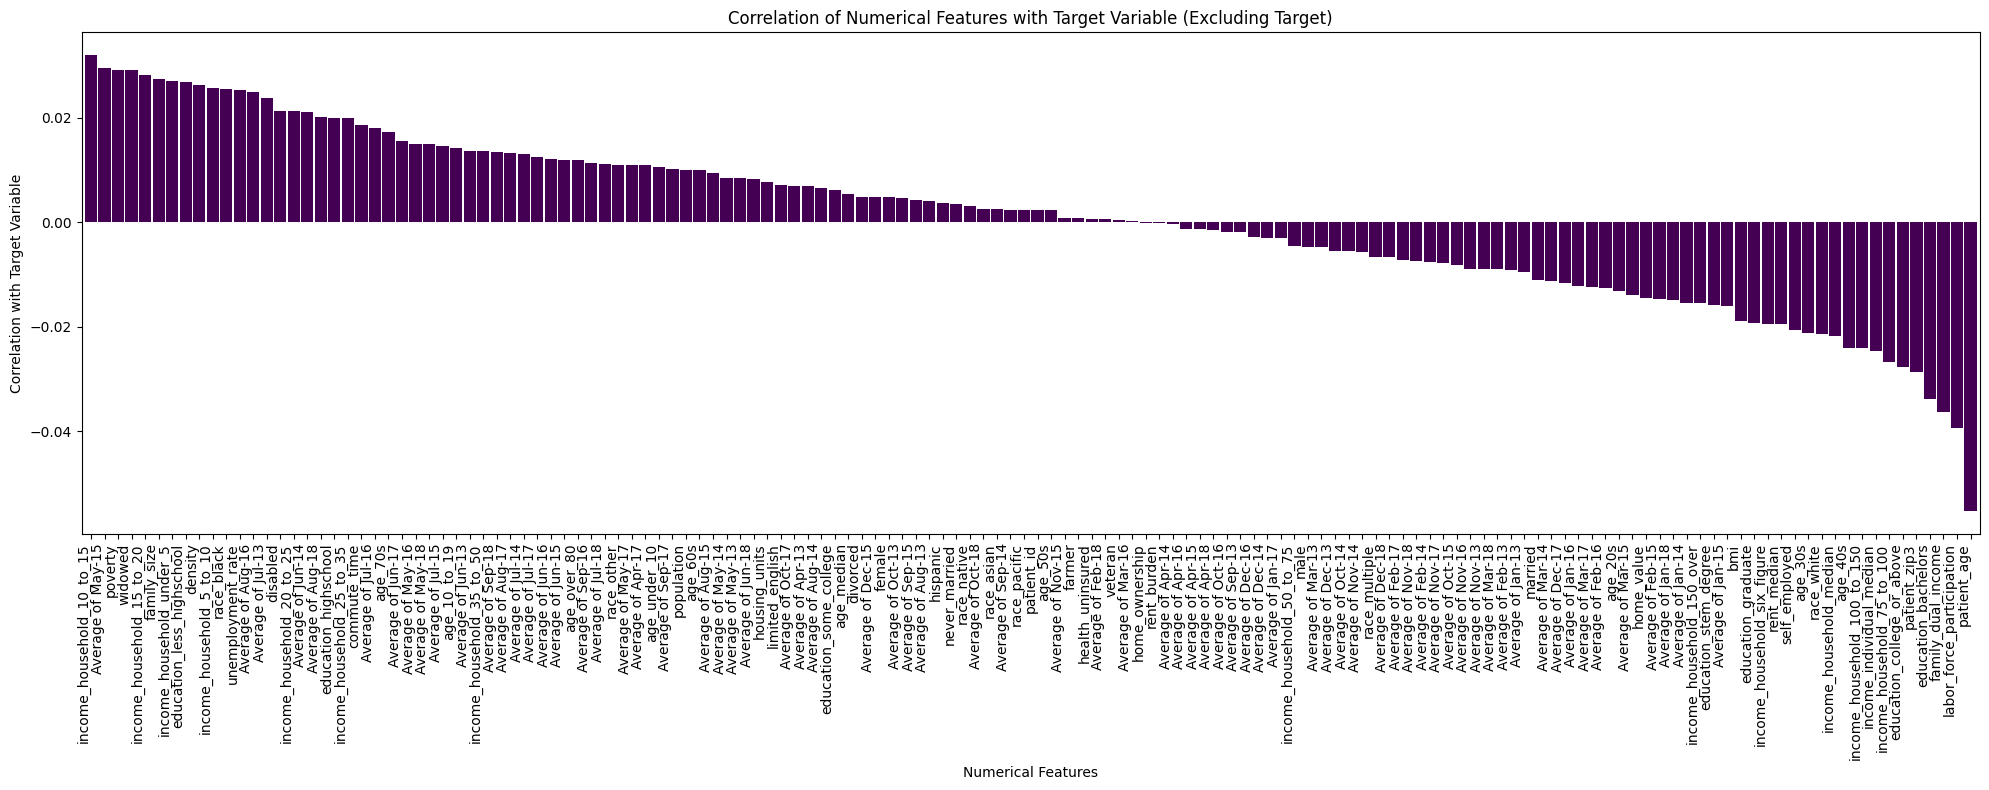

In [13]:
# Sort the correlations with the target variable
corr_with_target = corr_matrix[target_variable].sort_values(ascending=False)

# Drop the target variable from the correlation Series
corr_without_target = corr_with_target.drop(target_variable)

# Plotting the correlations without the target variable
plt.figure(figsize=(20, 8))  # Increase figure width to accommodate longer x-axis labels
bar_width = 0.9  # Adjust the width of the bars

# Specify a different color map
color_map = 'viridis'

# Plotting
corr_without_target.plot(kind='bar', colormap=color_map, width=bar_width)
plt.xlabel('Numerical Features')
plt.ylabel('Correlation with Target Variable')
plt.title('Correlation of Numerical Features with Target Variable (Excluding Target)')
plt.xticks(rotation=90, ha='right', fontsize=10)  # Rotate x-axis labels for better readability
plt.margins(x=0.11)  # Set margins to provide space for x-axis labels
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4133: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


Skipping ANOVA for patient_gender as there is only one group


<ipython-input-14-1798def5e273>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=anova_df, x='categorical_variable', y='f_value', palette='viridis')


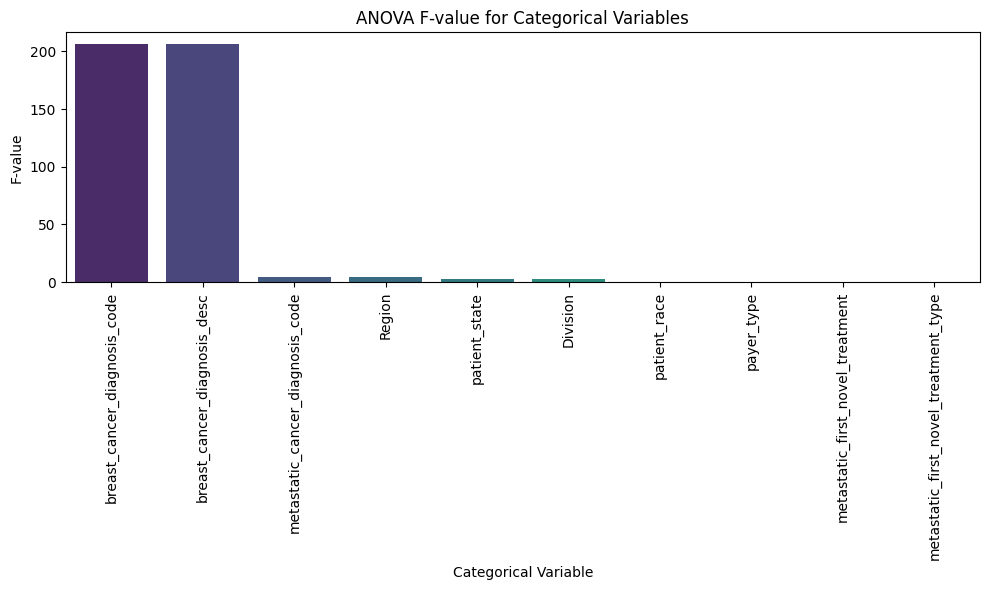

In [14]:
# Dictionary to hold the ANOVA results
anova_results = {}

# Define a function to perform ANOVA and store results
def perform_anova(df, categorical_column, target_column):
    groups = [df[target_column][df[categorical_column] == category] for category in df[categorical_column].unique()]
    if len(groups) < 2:
        print("Skipping ANOVA for", categorical_column, "as there is only one group")
        return None, None
    f_statistic, p_value = f_oneway(*groups)
    return f_statistic, p_value

# Perform ANOVA for each categorical variable against the target variable
for column in categorical_columns:
    f_statistic, p_value = perform_anova(train, column, 'metastatic_diagnosis_period')
    if f_statistic is not None:
        anova_results[column] = f_statistic

# Convert results to a DataFrame for sorting
anova_df = pd.DataFrame(list(anova_results.items()), columns=['categorical_variable', 'f_value'])

# Sort the DataFrame by F-value from max to min
anova_df = anova_df.sort_values(by='f_value', ascending=False)

# Plotting the ANOVA results
plt.figure(figsize=(10, 6))
sns.barplot(data=anova_df, x='categorical_variable', y='f_value', palette='viridis')
plt.title('ANOVA F-value for Categorical Variables')
plt.xlabel('Categorical Variable')
plt.ylabel('F-value')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [15]:
# Exclude the target variable and sort by absolute correlation values
corr_with_target = corr_matrix[target_variable].drop(target_variable).abs().sort_values(ascending=False).head(10)

# Print top 10 absolute correlation values (excluding the target variable)
print(f"Top 10 absolute correlations with '{target_variable}' (excluding itself):")
for col, corr_val in corr_with_target.items():
    print(f"{col}: {corr_val}")


Top 10 absolute correlations with 'metastatic_diagnosis_period' (excluding itself):
patient_age: 0.055231359481934965
labor_force_participation: 0.039368608644549864
family_dual_income: 0.03640348751137413
education_bachelors: 0.033842293355421896
income_household_10_to_15: 0.03197485109301944
Average of May-15: 0.029483726364884503
poverty: 0.029135428404253472
widowed: 0.029086316867978728
patient_zip3: 0.028686057480996174
income_household_15_to_20: 0.028111285426823878


In [16]:
# Sort by F-value in descending order and get the top 7
top_anova_df = anova_df.sort_values(by='f_value', ascending=False).head(7)

# Print top 7 categorical variables by ANOVA F-value
print("Top 7 categorical variables by ANOVA F-value:")
print(top_anova_df)


Top 7 categorical variables by ANOVA F-value:
               categorical_variable     f_value
5      breast_cancer_diagnosis_code  206.133897
6      breast_cancer_diagnosis_desc  206.133897
7  metastatic_cancer_diagnosis_code    4.731484
3                            Region    4.696268
2                     patient_state    2.920630
4                          Division    2.823486
0                      patient_race         NaN


In [17]:
# Combine the numerical and categorical results into one DataFrame
corr_with_target_df = corr_with_target.reset_index().rename(columns={'index': 'variable', target_variable: 'correlation'})
top_anova_df = top_anova_df.rename(columns={'categorical_variable': 'variable', 'f_value': 'value'})
combined_df = pd.concat([corr_with_target_df, top_anova_df], ignore_index=True)

# Add the target variable to the list of columns to include
columns_to_include = combined_df['variable'].tolist() + [target_variable]

# Filter train dataset to include only the columns in combined_df and the target variable
filtered_train = train[columns_to_include]

# Print the filtered train dataset
filtered_train.head()



,patient_age,labor_force_participation,family_dual_income,education_bachelors,income_household_10_to_15,Average of May-15,poverty,widowed,patient_zip3,income_household_15_to_20,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,Region,patient_state,Division,patient_race,metastatic_diagnosis_period
0,39,53.60,43.99,9.21,8.52,68.49,19.27,8.66,724,7.08,C50912,Malignant neoplasm of unspecified site of left...,C773,South,AR,West South Central,NaN,191
1,55,52.51,41.41,12.46,6.58,66.81,16.94,8.17,629,5.58,C50412,Malig neoplasm of upper-outer quadrant of left...,C773,Midwest,IL,East North Central,White,33
2,59,59.47,52.89,13.92,3.16,68.06,12.72,4.95,925,3.71,1749,"Malignant neoplasm of breast (female), unspeci...",C773,West,CA,Pacific,NaN,157
3,59,64.39,55.53,23.89,6.81,62.56,20.76,4.77,900,4.18,C50911,Malignant neoplasm of unsp site of right femal...,C773,West,CA,Pacific,Hispanic,146
4,71,55.20,51.88,19.14,2.56,58.19,10.34,5.01,934,2.59,1748,Malignant neoplasm of other specified sites of...,C7951,West,CA,Pacific,NaN,286


In [18]:
filtered_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13173 entries, 0 to 13172
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   patient_age                       13173 non-null  int64  
 1   labor_force_participation         13173 non-null  float64
 2   family_dual_income                13168 non-null  float64
 3   education_bachelors               13173 non-null  float64
 4   income_household_10_to_15         13168 non-null  float64
 5   Average of May-15                 13173 non-null  float64
 6   poverty                           13168 non-null  float64
 7   widowed                           13173 non-null  float64
 8   patient_zip3                      13173 non-null  int64  
 9   income_household_15_to_20         13168 non-null  float64
 10  breast_cancer_diagnosis_code      13173 non-null  object 
 11  breast_cancer_diagnosis_desc      13173 non-null  object 
 12  meta

# **Descriptive Statistics - Numerical and Categorical Columns**


In [ ]:
def describe_data(data):
    desc = pd.DataFrame({
        'type': data.dtypes,
        'count': data.count(),
        'nunique': data.nunique(),
        'unique%': data.nunique() / len(data) * 100,
        'null': data.isnull().sum(),
        'null%': data.isnull().sum() / len(data) * 100
    })

    desc = pd.concat([desc, data.describe().T.drop('count', axis=1)], axis=1)
    desc = desc.sort_values(by=['type', 'null%'])

    # Apply background gradient with Blues colormap
    styled_desc = desc.style.background_gradient(axis=0, cmap='Blues')

    return styled_desc

# Describe train data
styled_train_description = describe_data(filtered_train)

# Display styled description
styled_train_description

,type,count,nunique,unique%,null,null%,mean,std,min,25%,50%,75%,max
patient_age,int64,13173,67,0.508616,0,0.000000,59.271313,13.218883,18.000000,50.000000,59.000000,67.000000,91.000000
patient_zip3,int64,13173,751,5.701055,0,0.000000,568.530859,275.758485,100.000000,330.000000,557.000000,832.000000,995.000000
metastatic_diagnosis_period,int64,13173,366,2.778410,0,0.000000,96.515221,108.969873,0.000000,3.000000,44.000000,181.000000,365.000000
labor_force_participation,float64,13173,656,4.979883,0,0.000000,61.633658,5.977344,30.700000,57.960000,62.780000,65.680000,78.670000
education_bachelors,float64,13173,630,4.782510,0,0.000000,19.263585,6.255266,2.470000,13.980000,18.870000,23.890000,41.700000
Average of May-15,float64,13173,615,4.668640,0,0.000000,65.244507,6.306477,44.950000,61.460000,64.960000,68.800000,80.900000
widowed,float64,13173,439,3.332574,0,0.000000,5.846155,1.556496,0.000000,4.770000,5.550000,6.610000,20.650000
family_dual_income,float64,13168,666,5.055796,5,0.037956,51.800184,6.696196,19.310000,47.732500,52.590000,56.160000,65.640000
income_household_10_to_15,float64,13168,451,3.423670,5,0.037956,4.159681,1.751091,1.020000,2.900000,3.790000,5.090000,14.280000
poverty,float64,13168,615,4.668640,5,0.037956,13.417748,5.105035,3.430000,9.870000,12.210000,16.410000,38.350000


# **Plot of Missing Values**

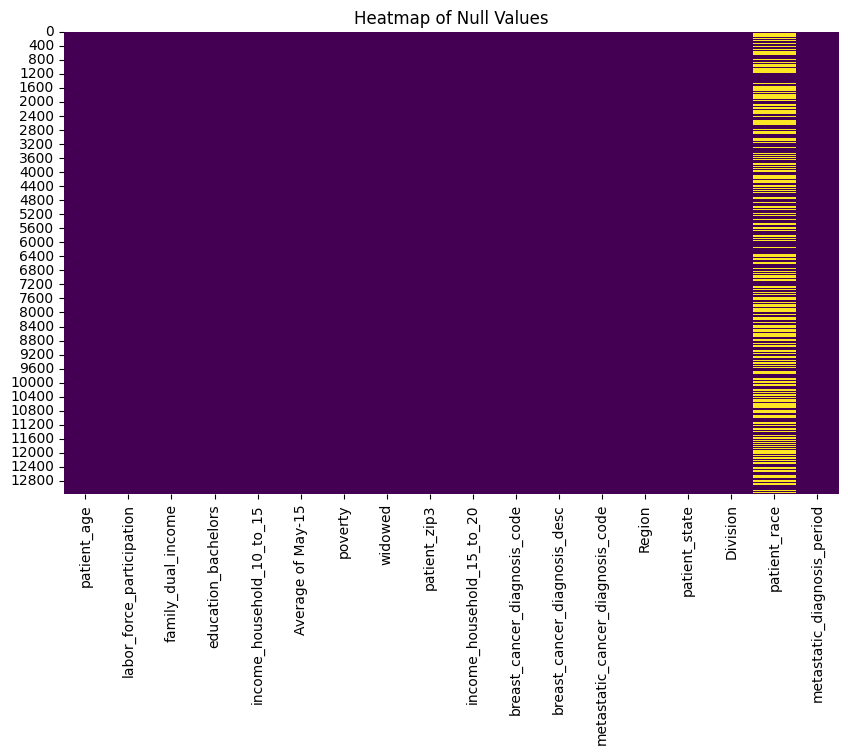

In [ ]:
# Create a heatmap for null values
plt.figure(figsize=(10, 6))
sns.heatmap(filtered_train.isnull(), cmap='viridis', cbar=False)
plt.title('Heatmap of Null Values')
plt.show()


# **Exploratory Data Analysis (EDA)**

In [ ]:
# Get numerical columns of filtered data
filtered_numeric_cols = filtered_train.select_dtypes(include=['int64', 'float64']).columns

# Get categorical columns of filtered data
filtered_categorical_columns = filtered_train.select_dtypes(include=['object']).columns

# **Box Plots- Numerical Columns**

### How are the numerical variables distributed across the dataset, and what insights can be derived from their distributions?






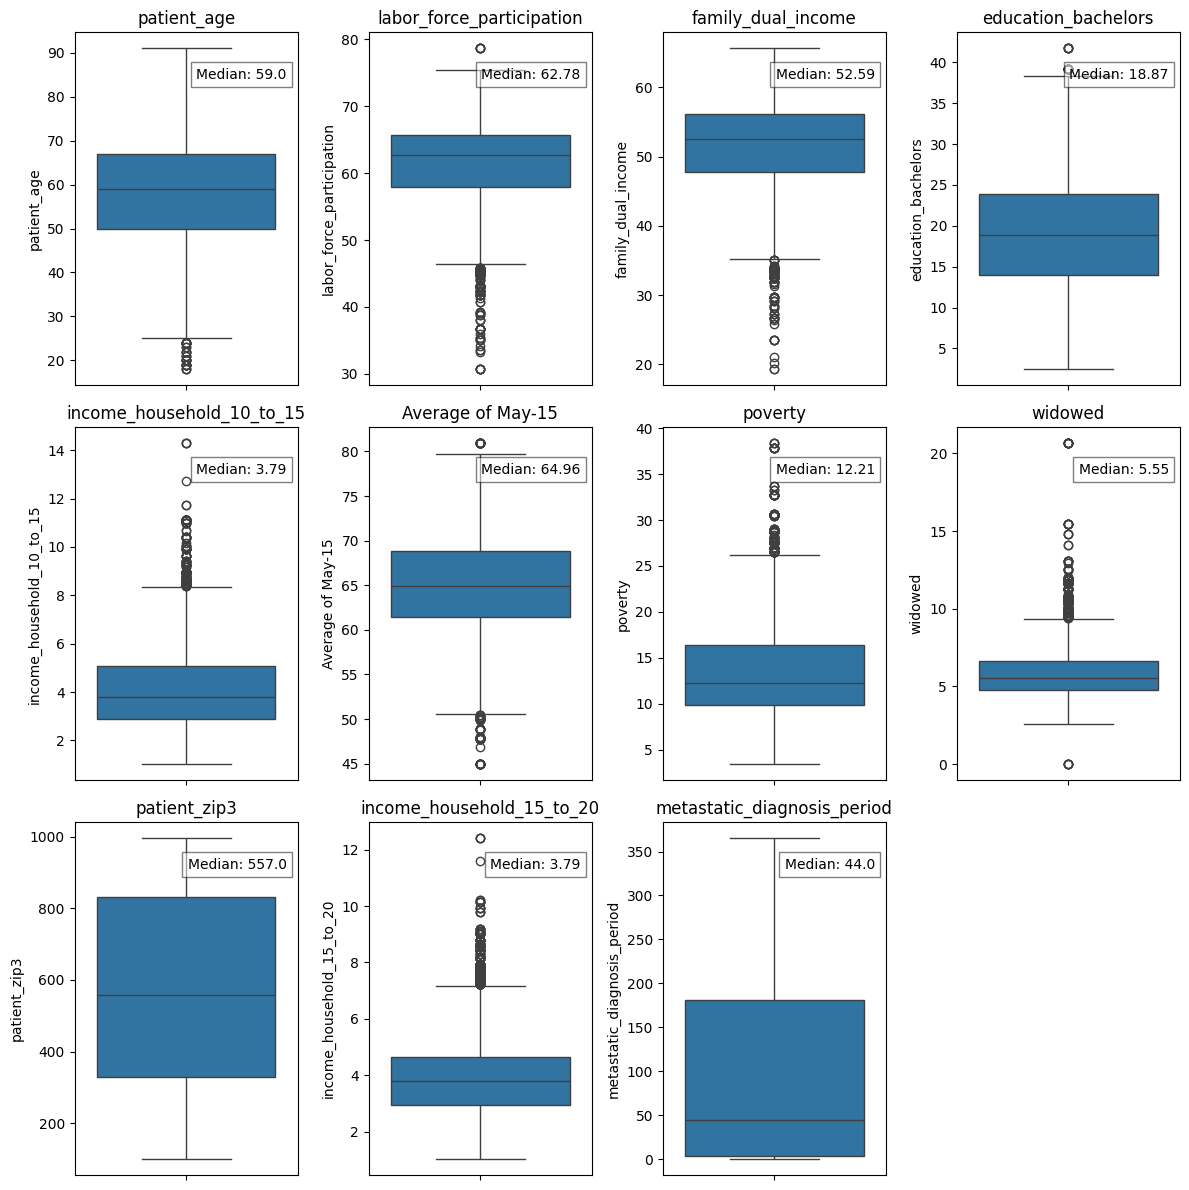

In [ ]:
# Adjusting the subplot grid size to accommodate all numeric columns
num_cols = len(filtered_numeric_cols)
num_rows = (num_cols // 4) + (1 if num_cols % 4 else 0)  # Adjust the number of rows in the grid

plt.figure(figsize=(12, num_rows * 4))

for i, col in enumerate(filtered_numeric_cols, 1):
    ax = plt.subplot(num_rows, 4, i)
    sns.boxplot(data=filtered_train[col], ax=ax)
    ax.set_title(col)

    # Annotate median value
    median_val = filtered_train[col].median()
    ax.text(0.95, 0.9, f'Median: {median_val}', verticalalignment='top', horizontalalignment='right',
            transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()


## **Histograms - Numerical Columns**

### How are the numerical variables distributed across the dataset, and what insights can be derived from their distributions?


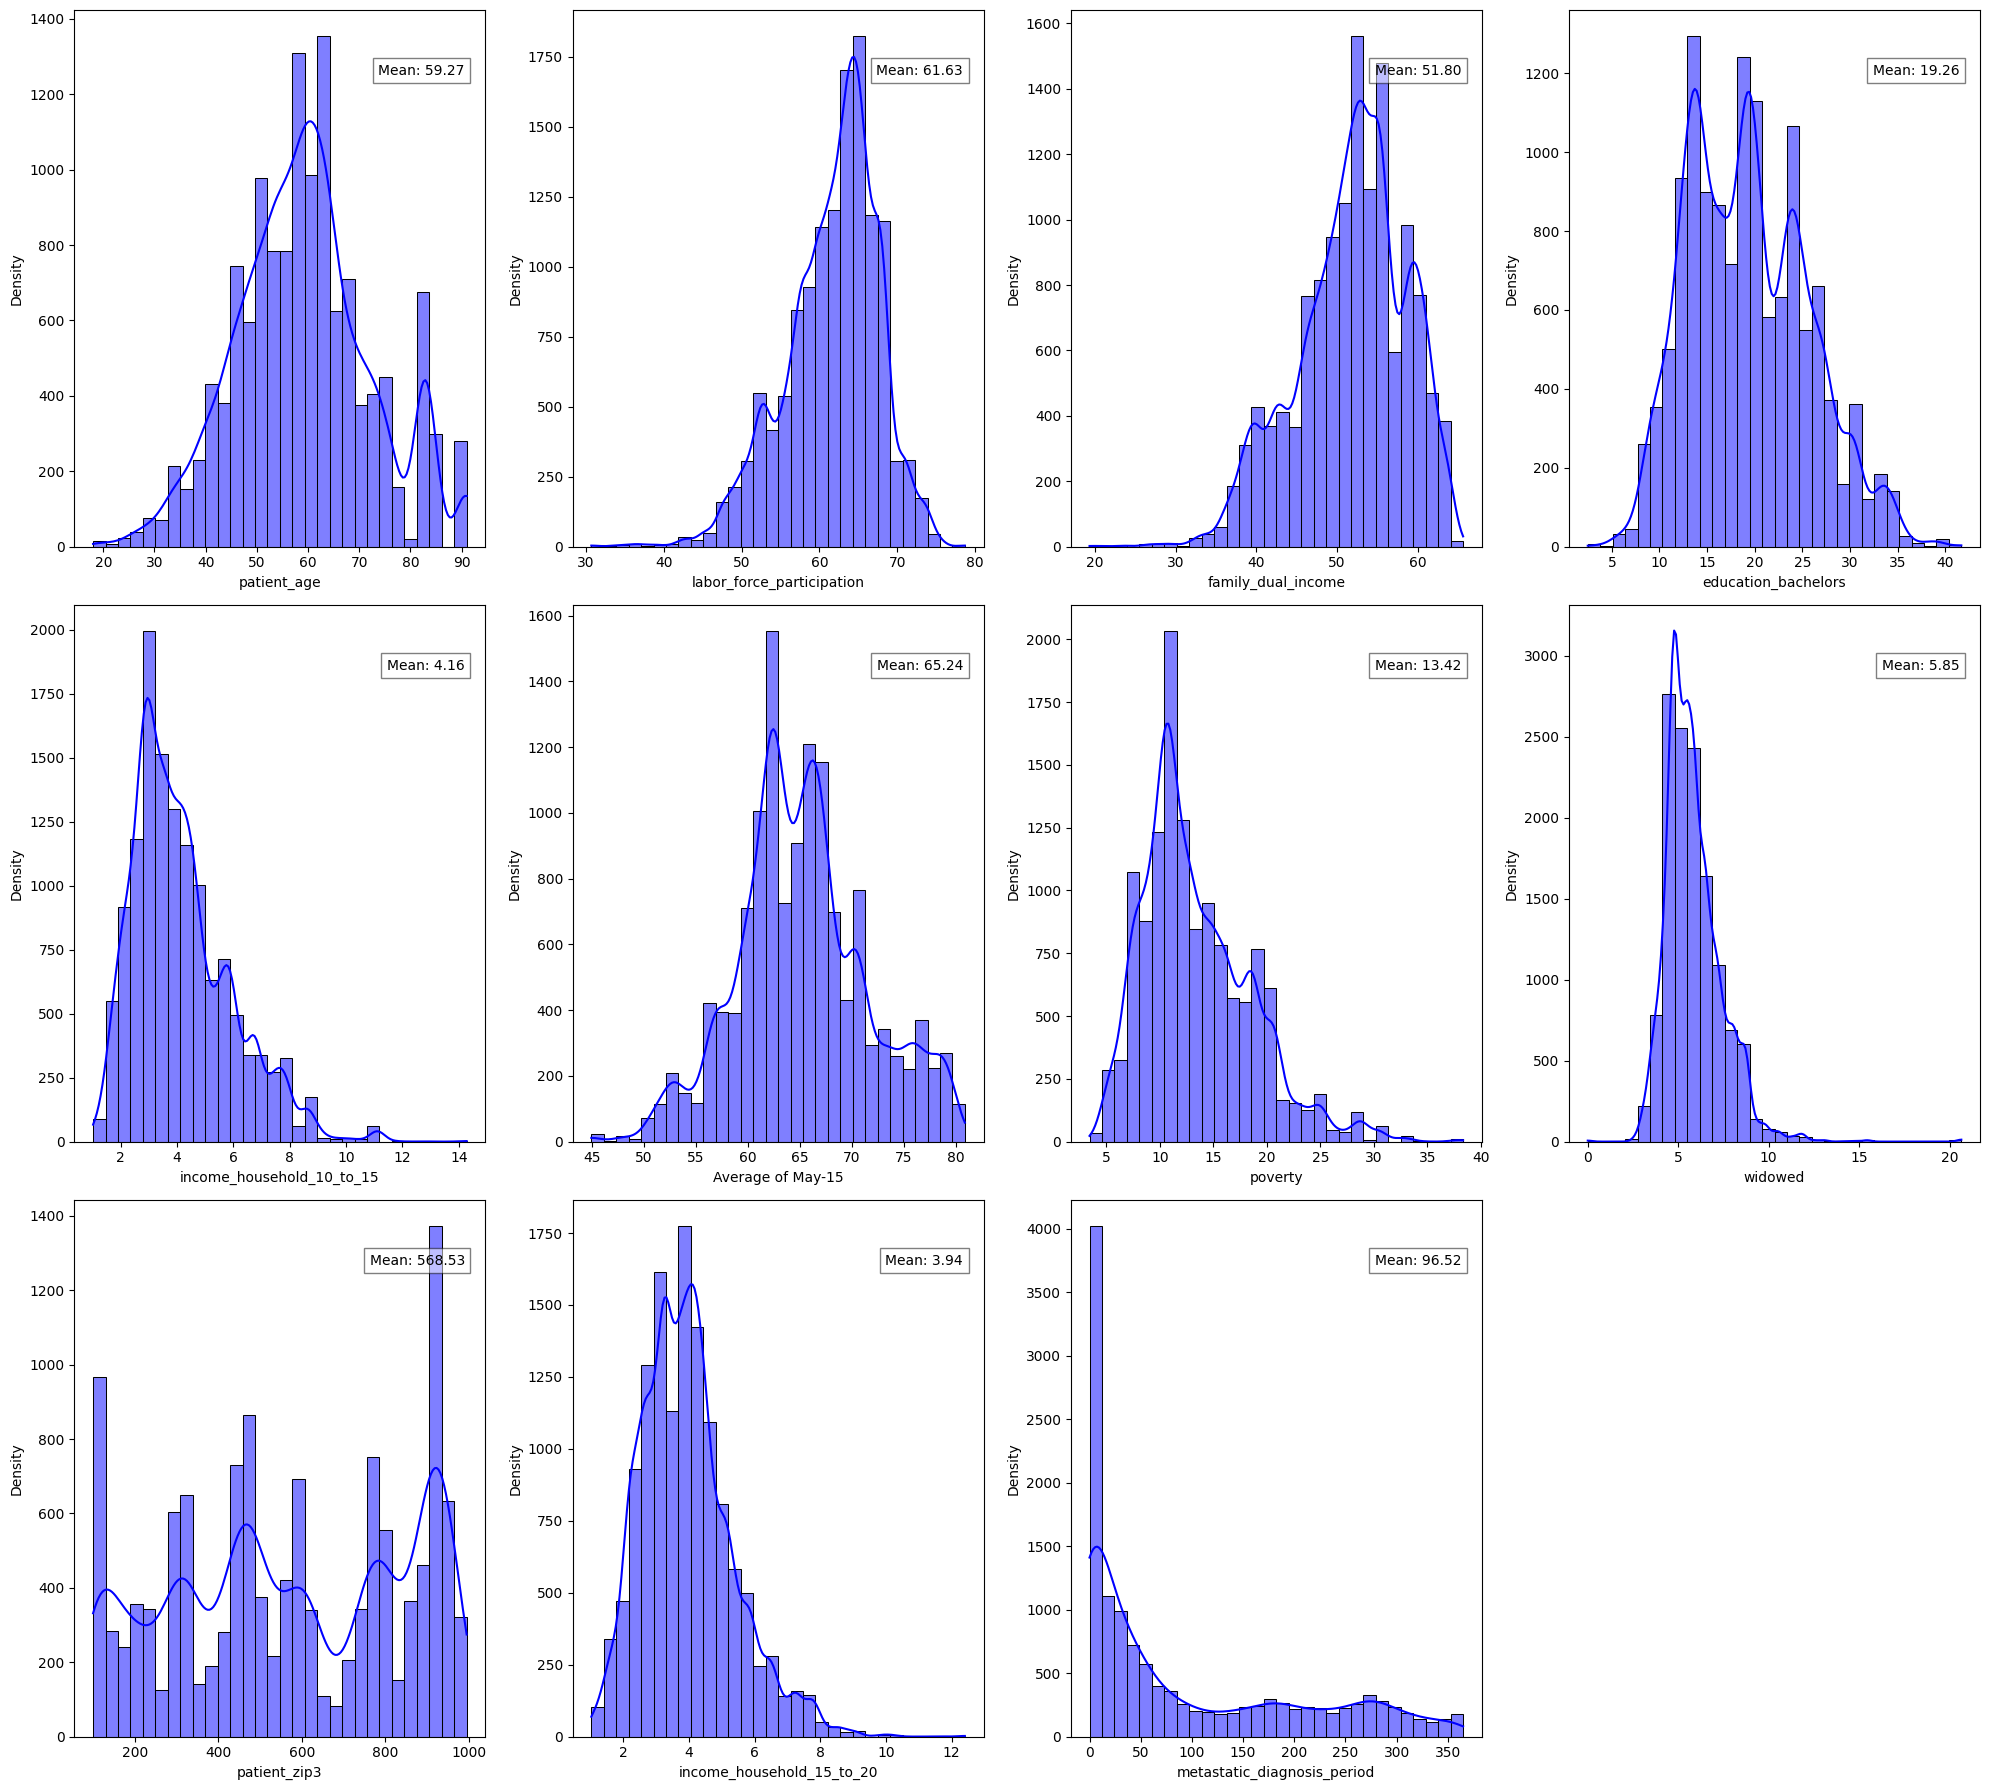

In [ ]:
# Calculate the number of rows and columns needed for subplots
num_columns = len(filtered_numeric_cols)
num_rows = math.ceil(num_columns / 4)

# Setting up the figure size
plt.figure(figsize=(20, 6 * num_rows))

# Looping through each numerical column to create histograms
for i, column in enumerate(filtered_numeric_cols, 1):
    plt.subplot(num_rows, 4, i)
    sns.histplot(filtered_train[column].dropna(), kde=True, color='blue', alpha=0.5, bins=30)
    plt.xlabel(column)
    plt.ylabel('Density')

    # Calculate mean value
    mean_val = filtered_train[column].mean()

    # Annotate mean value
    plt.text(0.95, 0.9, f'Mean: {mean_val:.2f}', verticalalignment='top', horizontalalignment='right',
             transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

# Adjust layout
plt.tight_layout()
plt.show()


# **Bar Plots - Categorical Columns**


### How do different categories within each categorical variable compare in terms of their frequency or distribution?


<ipython-input-24-23d8190293b1>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=filtered_train, x=column, palette=custom_palette)
<ipython-input-24-23d8190293b1>:13: UserWarning: 
The palette list has fewer values (6) than needed (47) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(data=filtered_train, x=column, palette=custom_palette)
<ipython-input-24-23d8190293b1>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=filtered_train, x=column, palette=custom_palette)
<ipython-input-24-23d8190293b1>:13: UserWarning: 
The palette list has fewer values (6) than needed (47) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(data=

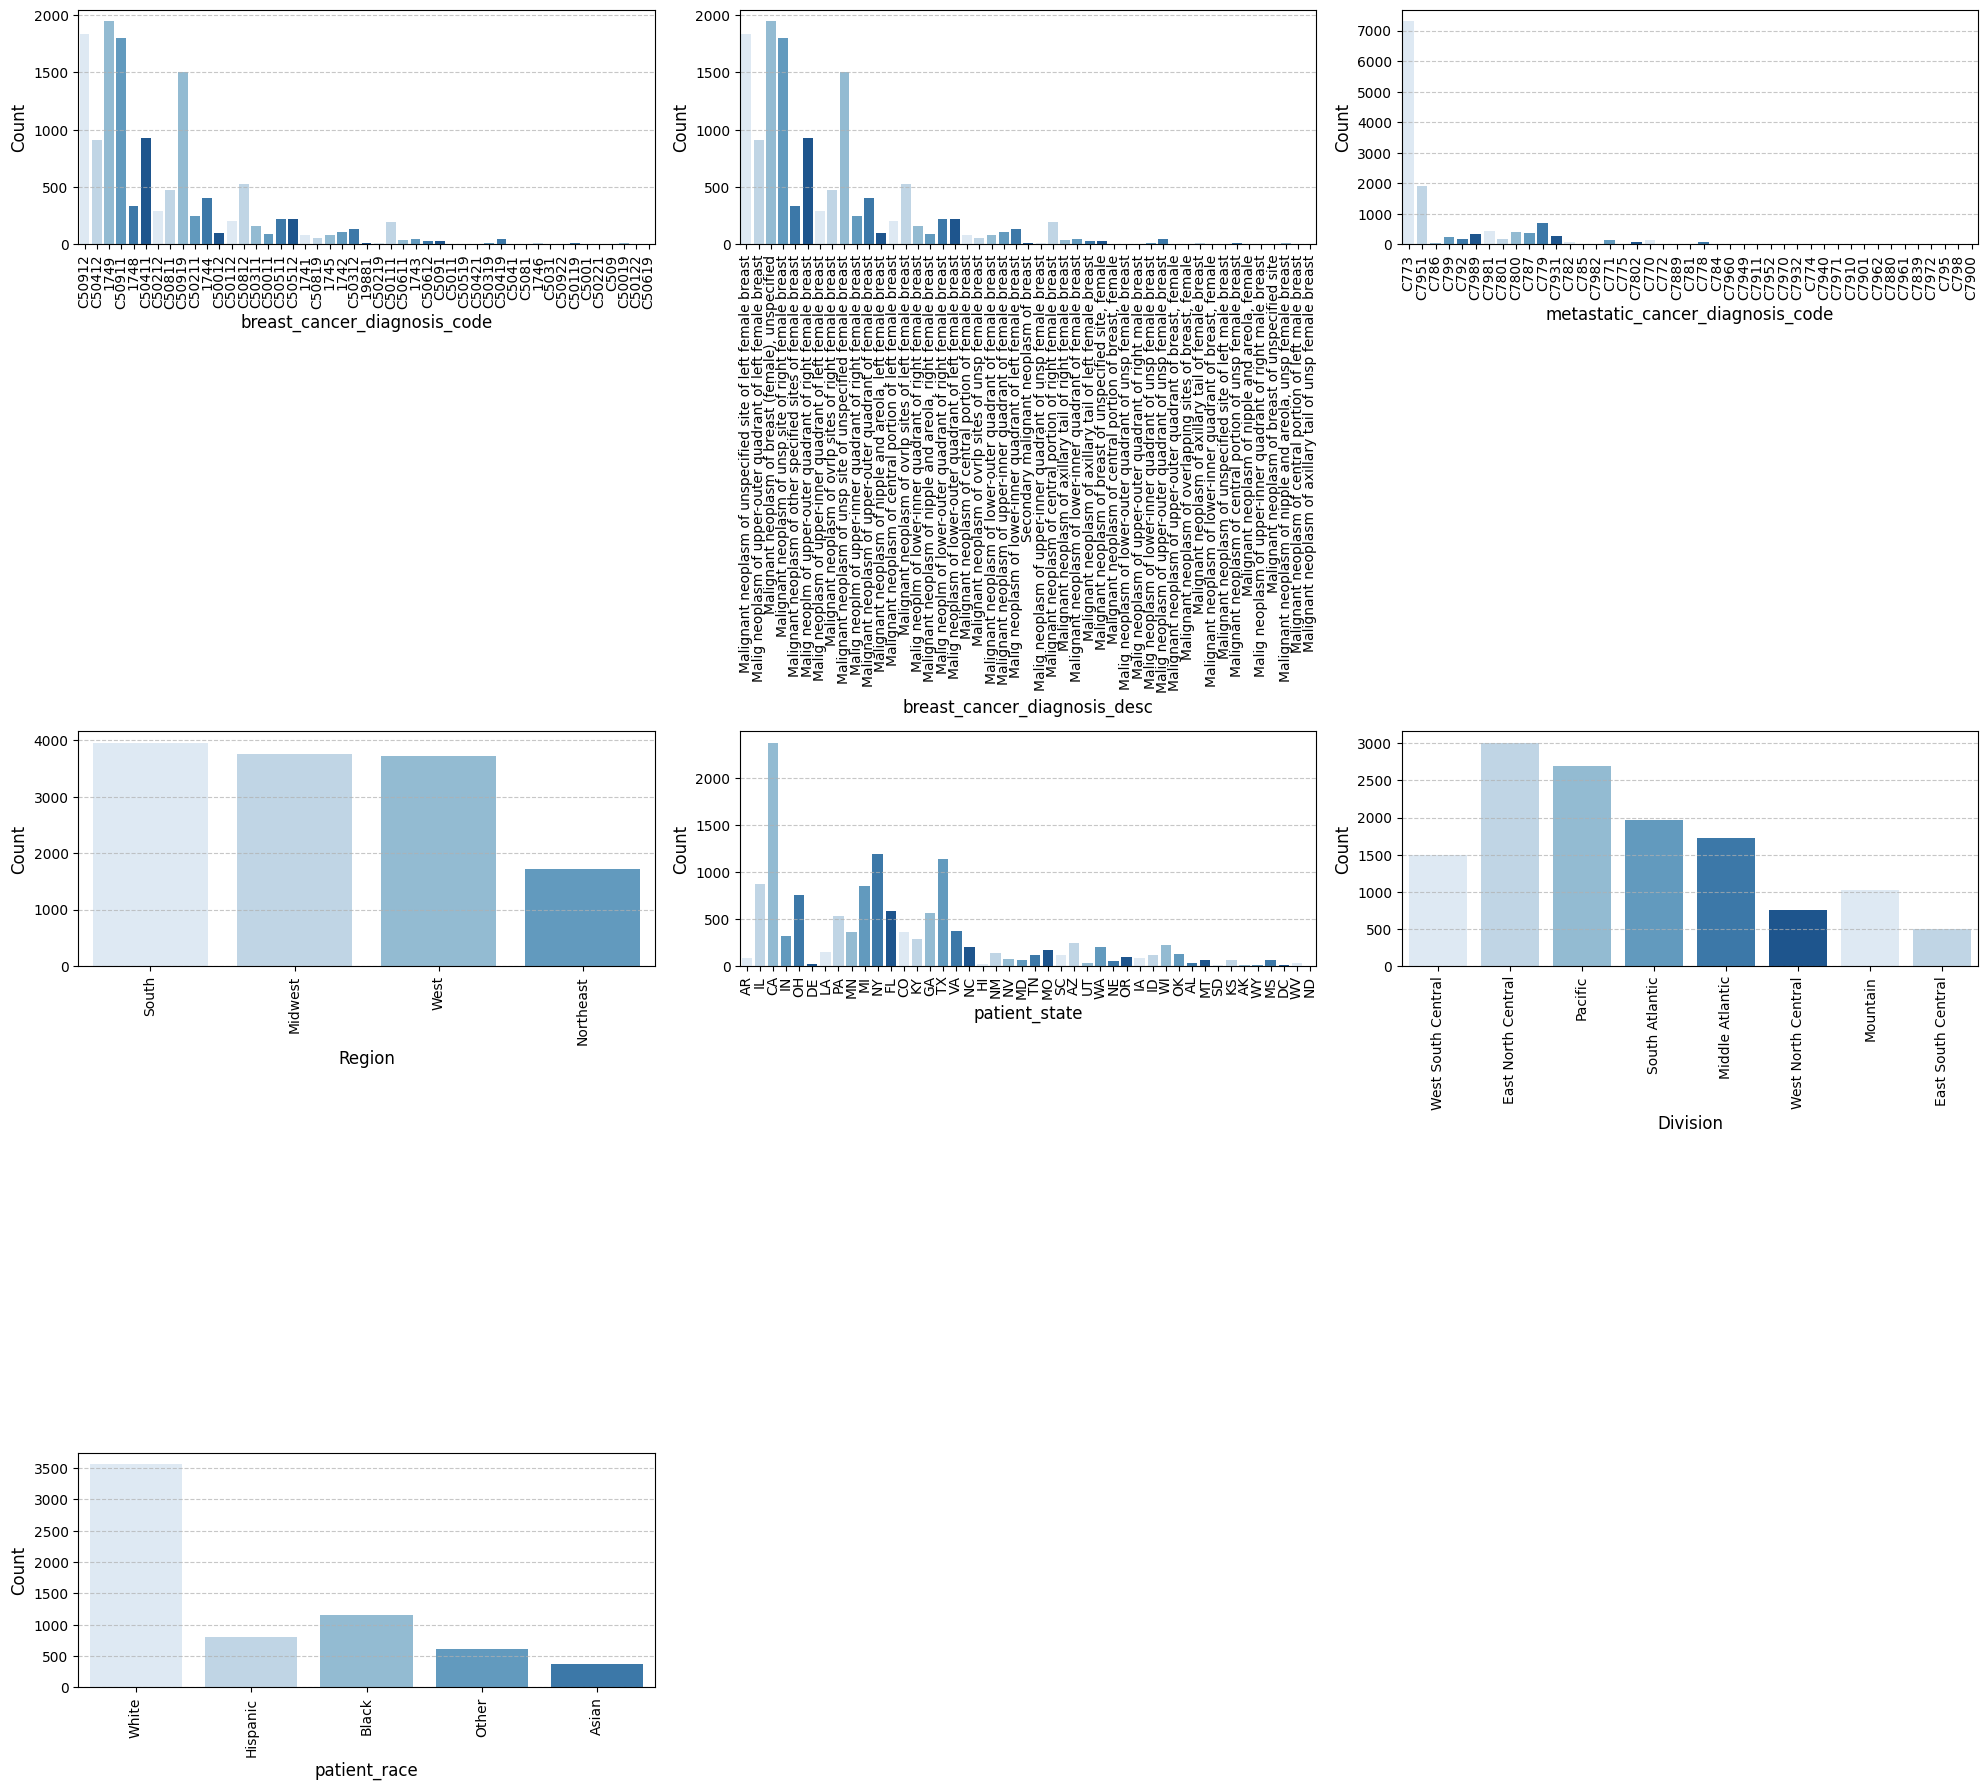

In [ ]:


# Calculate the number of rows needed based on the number of categorical columns
num_rows = (len(filtered_categorical_columns) + 2) // 3  # Add 2 for rounding up

# Setting up the figure size
plt.figure(figsize=(20, num_rows * 6))  # Adjust the height based on the number of rows

# Define custom color palette
custom_palette = sns.color_palette("Blues")

# Looping through each categorical column to create count plots
for i, column in enumerate(filtered_categorical_columns, 1):
    plt.subplot(num_rows, 3, i)  # Adjust the number of columns to 3
    sns.countplot(data=filtered_train, x=column, palette=custom_palette)
    plt.xlabel(column, fontsize=12)  # Increase font size for x-label
    plt.ylabel('Count', fontsize=12)  # Increase font size for y-label
    plt.xticks(rotation=90, fontsize=10)  # Rotate x-axis labels by 90 degrees and increase font size
    plt.yticks(fontsize=10)  # Increase font size for y-axis labels
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines on y-axis with dashed style

plt.tight_layout()
plt.show()

## **Plotting the distribution of the target column**

### How is the frequency distribution of metastatic diagnosis periods distributed among patients?

### How is the distribution of metastatic diagnosis periods categorized as 90 days or less versus more than 90 days among patients?


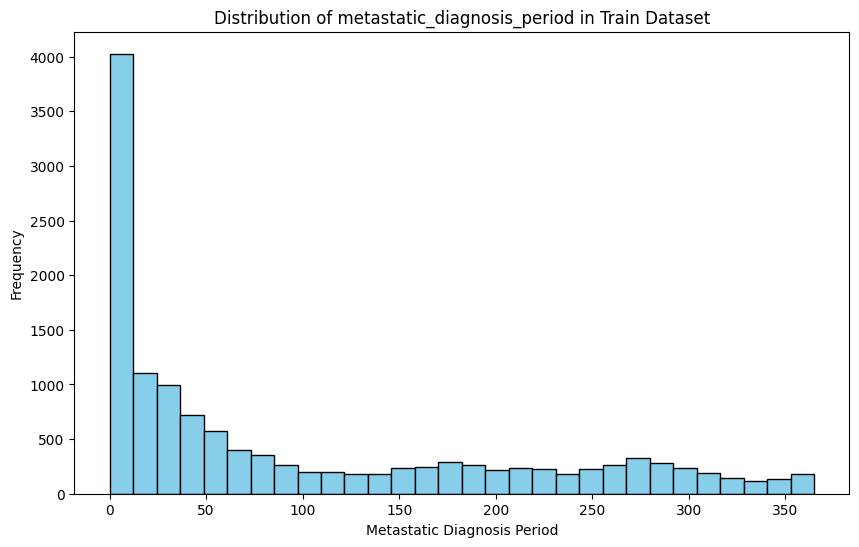

In [ ]:
# Plotting the distribution of the target column in the train dataset
plt.figure(figsize=(10, 6))
plt.hist(filtered_train['metastatic_diagnosis_period'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Metastatic Diagnosis Period')
plt.ylabel('Frequency')
plt.title('Distribution of metastatic_diagnosis_period in Train Dataset')
plt.show()

## **New Column as MDiagPeriod90D**

<ipython-input-26-821ec77db096>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_train['MDiagPeriod90D'] = (filtered_train['metastatic_diagnosis_period'] <= 90).astype(int)


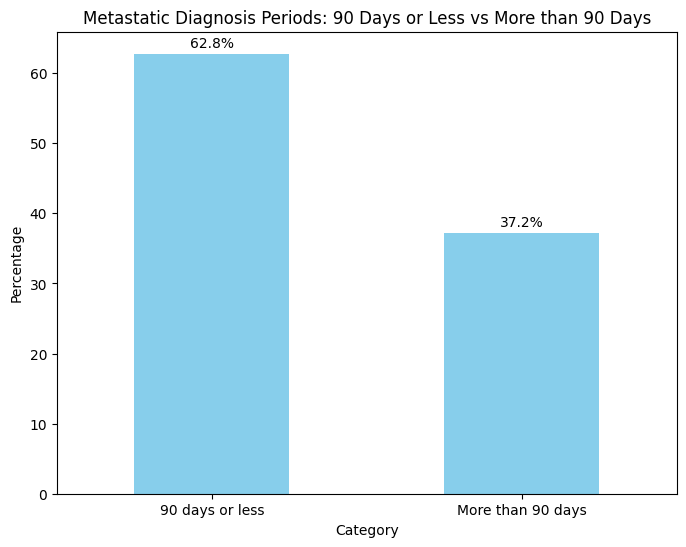

In [ ]:
# Create a new column MDiagPeriod90D in train_df to represent whether the metastatic diagnosis period
# is 90 days or less. assigns a value of 1 if the period is 90 days or less, and 0 otherwise.
filtered_train['MDiagPeriod90D'] = (filtered_train['metastatic_diagnosis_period'] <= 90).astype(int)


# Plot the counts of each category with percentage labels
plt.figure(figsize=(8, 6))
total = len(filtered_train['MDiagPeriod90D'])
percentages = filtered_train['MDiagPeriod90D'].value_counts() / total * 100
ax = percentages.plot(kind='bar', color='skyblue')

# Add percentage labels on top of each bar
for i, percentage in enumerate(percentages):
    plt.text(i, percentage + 0.5, f"{percentage:.1f}%", ha='center', va='bottom')

plt.title('Metastatic Diagnosis Periods: 90 Days or Less vs More than 90 Days')
plt.xlabel('Category')
plt.ylabel('Percentage')

# Add custom text to x-axis ticks
plt.xticks(ticks=[0, 1], labels=['90 days or less', 'More than 90 days'], rotation=0)

plt.show()

In [ ]:
filtered_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13173 entries, 0 to 13172
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   patient_age                       13173 non-null  int64  
 1   labor_force_participation         13173 non-null  float64
 2   family_dual_income                13168 non-null  float64
 3   education_bachelors               13173 non-null  float64
 4   income_household_10_to_15         13168 non-null  float64
 5   Average of May-15                 13173 non-null  float64
 6   poverty                           13168 non-null  float64
 7   widowed                           13173 non-null  float64
 8   patient_zip3                      13173 non-null  int64  
 9   income_household_15_to_20         13168 non-null  float64
 10  breast_cancer_diagnosis_code      13173 non-null  object 
 11  breast_cancer_diagnosis_desc      13173 non-null  object 
 12  meta

## **Analysis of Age Data**

### What is the distribution of patients across different age groups in the dataset?

### How does the distribution of `MDiagPeriod90D` (Metastatic Diagnosis Period within 90 days) vary across different age groups?

### How does the average metastatic diagnosis period vary across different age groups in the dataset?


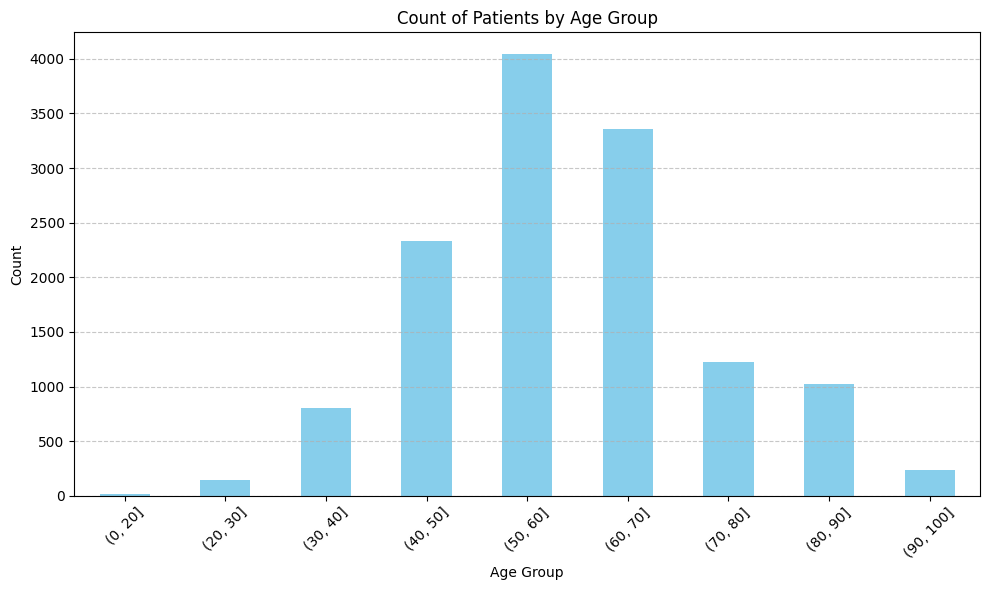

In [ ]:
# Define bins for age groups
bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Use pd.cut to create age groups
age_groups = pd.cut(filtered_train['patient_age'], bins=bins)

# Calculate the count of each age group
age_group_counts = age_groups.value_counts().sort_index()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
age_group_counts.plot(kind='bar', color='skyblue')
plt.title('Count of Patients by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


<ipython-input-29-b963b3017e27>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_train['age_bin'] = pd.cut(filtered_train['patient_age'], bins=age_bins, labels=age_labels, right=False)


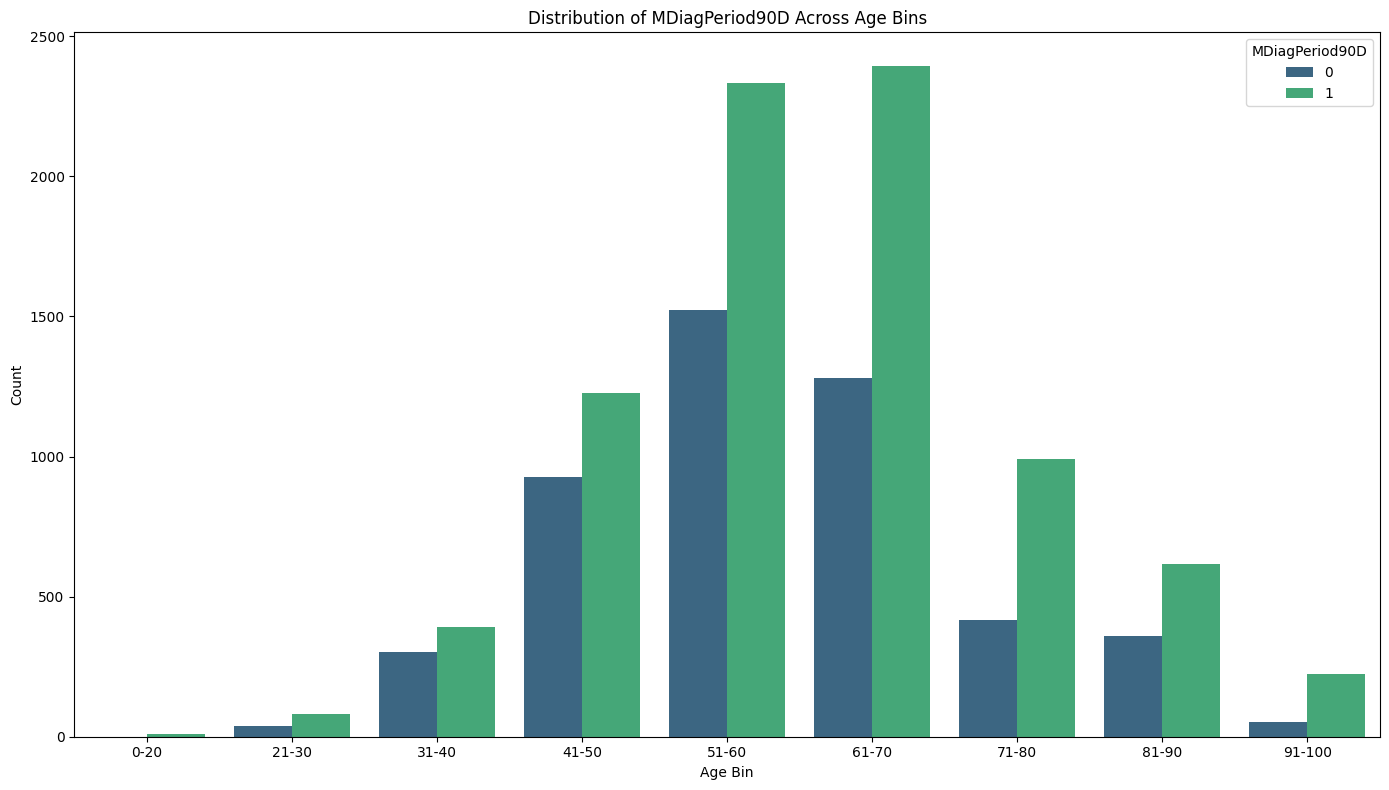

In [ ]:
# Create age bins
age_bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100]
age_labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']
filtered_train['age_bin'] = pd.cut(filtered_train['patient_age'], bins=age_bins, labels=age_labels, right=False)

# Create a count plot
plt.figure(figsize=(14, 8))
sns.countplot(x='age_bin', hue='MDiagPeriod90D', data=filtered_train, palette='viridis')
plt.title('Distribution of MDiagPeriod90D Across Age Bins')
plt.xlabel('Age Bin')
plt.ylabel('Count')
plt.legend(title='MDiagPeriod90D')
plt.tight_layout()
plt.show()


<ipython-input-30-12247a118fbc>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_train['age_bin'] = pd.cut(filtered_train['patient_age'], bins=bins, labels=labels, right=False)
<ipython-input-30-12247a118fbc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='age_bin', y='metastatic_diagnosis_period', data=mean_target_by_age_bin, palette='viridis')


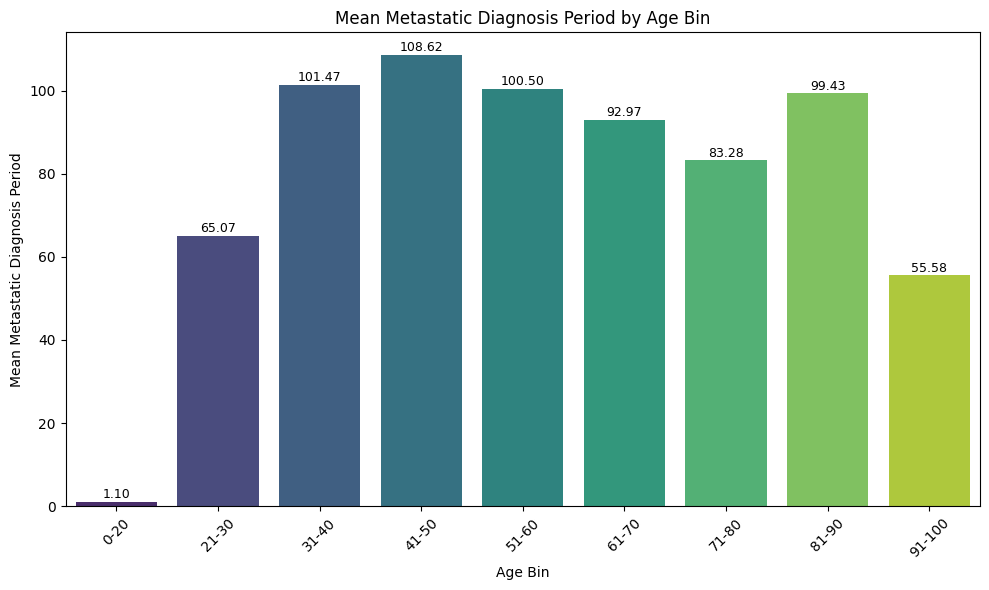

In [ ]:
# Define bins for age groups
bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']

# Use pd.cut to create age groups
filtered_train['age_bin'] = pd.cut(filtered_train['patient_age'], bins=bins, labels=labels, right=False)

# Calculate mean target for each age bin
mean_target_by_age_bin = filtered_train.groupby('age_bin')['metastatic_diagnosis_period'].mean().reset_index()

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='age_bin', y='metastatic_diagnosis_period', data=mean_target_by_age_bin, palette='viridis')
plt.title('Mean Metastatic Diagnosis Period by Age Bin')
plt.xlabel('Age Bin')
plt.ylabel('Mean Metastatic Diagnosis Period')
plt.xticks(rotation=45)
plt.tight_layout()

# Annotate each bar with the mean value
for index, row in mean_target_by_age_bin.iterrows():
    plt.text(index, row['metastatic_diagnosis_period'] + 0.1, f'{row["metastatic_diagnosis_period"]:.2f}',
             ha='center', va='bottom', fontsize=9)

plt.show()


## **Analysis of Region**

### How are patients distributed across various regions?

### What is the variation in metastatic diagnosis periods across different regions based on the dataset?


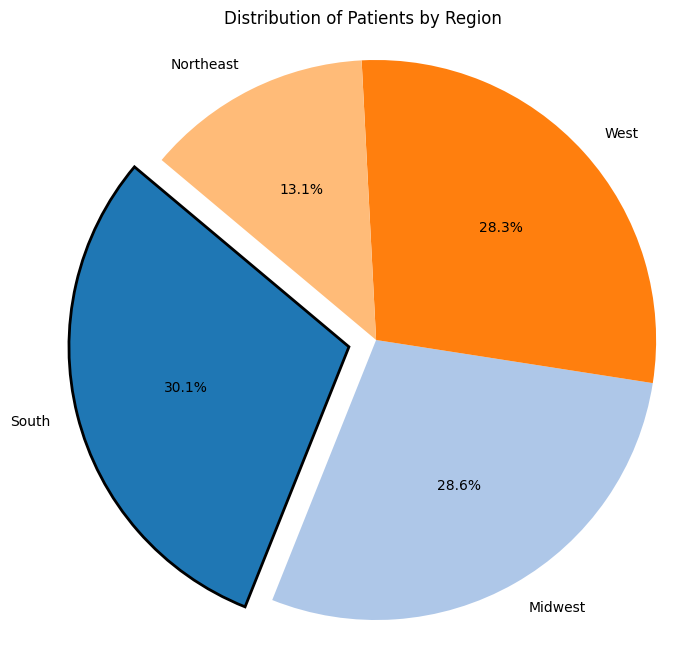

In [ ]:
# Example data (replace with your actual data)
region_counts = filtered_train['Region'].value_counts()

# Define custom colors for each region
colors = plt.cm.tab20.colors[:len(region_counts)]

# Find the index of the largest value in region_counts
max_index = region_counts.idxmax()

# Create an explode array where the largest piece is slightly separated
explode = [0.1 if region_counts.index[i] == max_index else 0 for i in range(len(region_counts))]

# Plotting the pie chart with shadows and custom explode
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(region_counts, labels=region_counts.index, autopct='%1.1f%%', startangle=140, colors=colors, explode=explode)
plt.title('Distribution of Patients by Region')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Highlighting the largest segment with a bold outline
for i, wedge in enumerate(wedges):
    if region_counts.index[i] == max_index:
        wedge.set_edgecolor('black')
        wedge.set_linewidth(2)

plt.show()





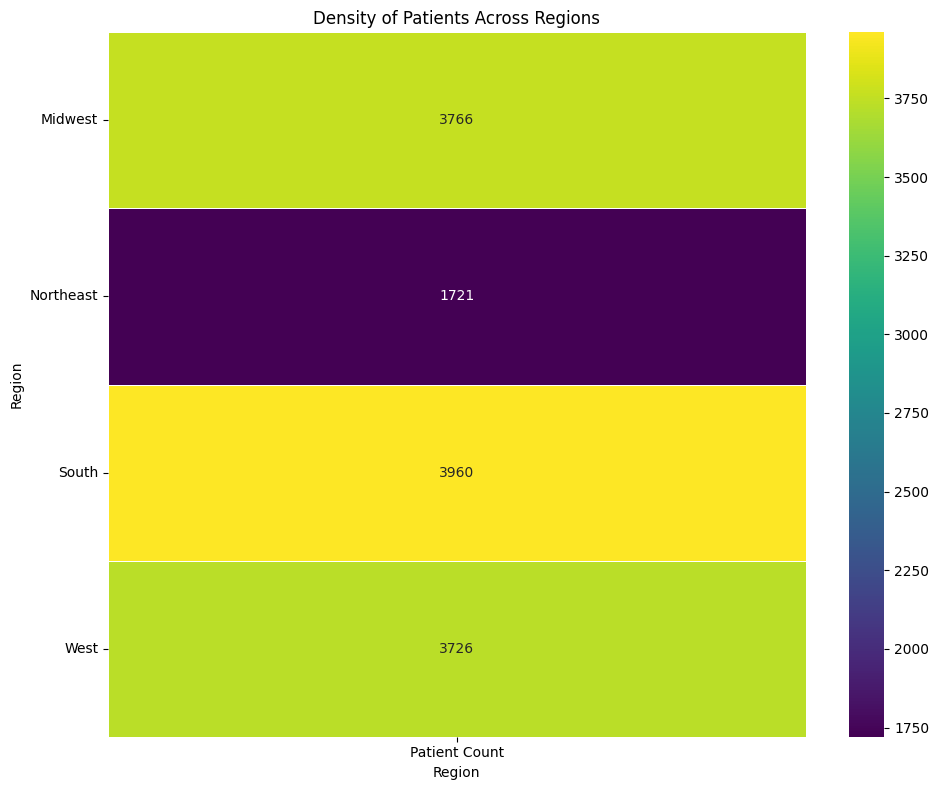

In [ ]:
# Aggregate data by region (example: count of patients per region)
region_counts = filtered_train['Region'].value_counts().reset_index()
region_counts.columns = ['Region', 'Patient Count']

# Pivot the data for heatmap visualization using pivot_table
heatmap_data = region_counts.pivot_table(index='Region', values='Patient Count', aggfunc='sum')

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt='d', linewidths=.5)
plt.title('Density of Patients Across Regions')
plt.xlabel('Region')
plt.ylabel('Region')
plt.yticks(rotation=0)  # Rotate y-axis labels if necessary
plt.tight_layout()
plt.show()


<ipython-input-33-29f69e0670cb>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Region', y='metastatic_diagnosis_period', data=filtered_train, palette='viridis')


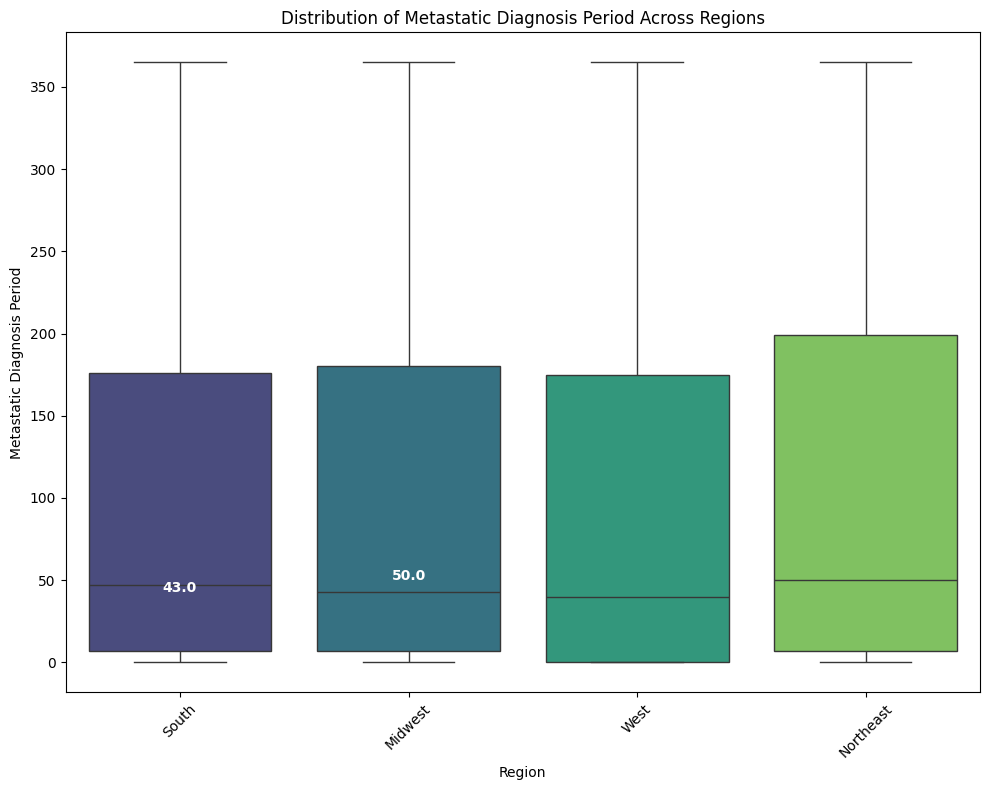

In [ ]:
# Create box plot using seaborn
plt.figure(figsize=(10, 8))
sns.boxplot(x='Region', y='metastatic_diagnosis_period', data=filtered_train, palette='viridis')

# Annotate with median values
medians = filtered_train.groupby('Region')['metastatic_diagnosis_period'].median().values
median_labels = [str(np.round(s, 2)) for s in medians]

for tick, label in zip(range(len(medians)), ax.get_xticklabels()):
    plt.text(tick, medians[tick], median_labels[tick],
             horizontalalignment='center', size='medium', color='white', weight='semibold')

plt.title('Distribution of Metastatic Diagnosis Period Across Regions')
plt.xlabel('Region')
plt.ylabel('Metastatic Diagnosis Period')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



## **Analysis of Patient Race**

### What is the distribution of patients across different racial groups in the dataset?

### How does the distribution of patient races vary across different age groups?

### How does the distribution of patient races vary across different regions and states?


### How does the metastatic diagnosis period vary among different patient races according to the dataset?




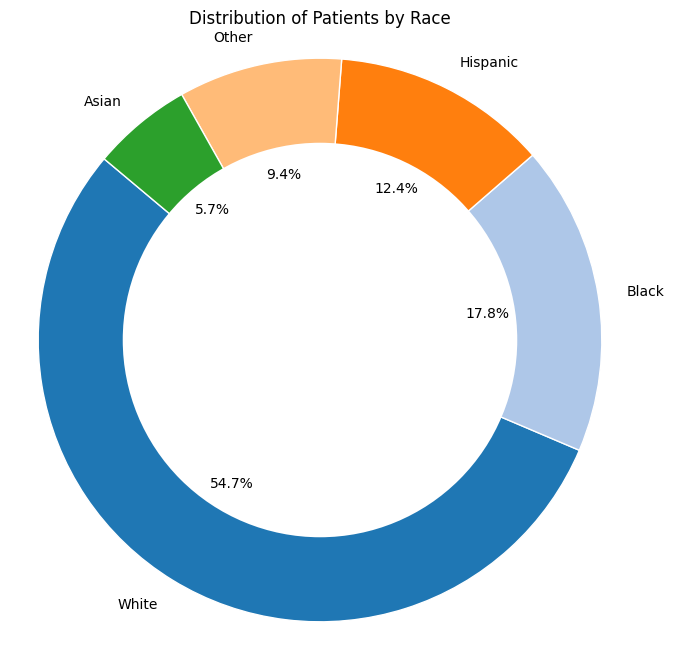

In [ ]:
# Example data (replace with your actual data)
race_counts = filtered_train['patient_race'].value_counts()

# Define custom colors for each region
colors = plt.cm.tab20.colors[:len(race_counts)]

# Find the index of the largest value in race_counts
max_index = race_counts.idxmax()

# Create an explode array where the largest piece is slightly separated
explode = [0.1 if race_counts.index[i] == max_index else 0 for i in range(len(race_counts))]

# Plotting the donut chart with shadows and custom explode
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    race_counts,
    labels=race_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
)

# Draw a circle at the center to create the donut hole
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)


plt.title('Distribution of Patients by Race')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


<ipython-input-35-7bd8a23d271b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_train['age_bin'] = pd.cut(filtered_train['patient_age'], bins=bins, labels=labels, right=False)


<Figure size 2000x1000 with 0 Axes>

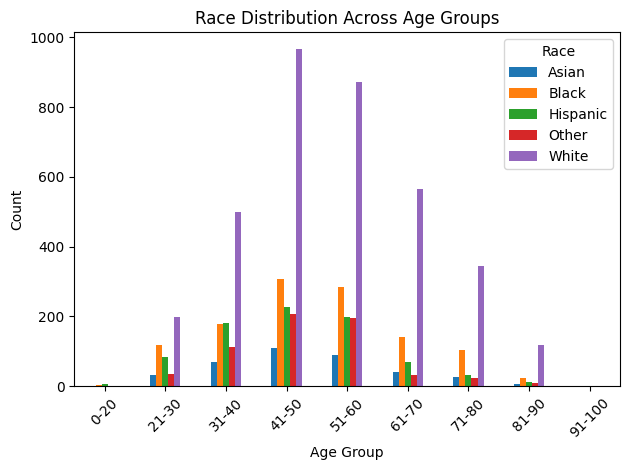

In [ ]:
 # Define bins and labels for age groups
bins = [0, 20, 40,50, 60, 70, 80,90,100, float('inf')]  # Example bins: 0-20, 21-40, 41-60, 61-80, 81+
labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']

# Add a new column 'age_bin' based on 'patient_age'
filtered_train['age_bin'] = pd.cut(filtered_train['patient_age'], bins=bins, labels=labels, right=False)

# Visualize Race Distribution Across Age Groups
# Drop rows where patient_race is null
filtered_data = filtered_train.dropna(subset=['patient_race', 'age_bin'])

# Group by 'age_bin' and 'patient_race' and count occurrences
race_age_counts = filtered_data.groupby(['age_bin', 'patient_race']).size().unstack()

# Plotting the grouped bar chart
plt.figure(figsize=(20, 10))
race_age_counts.plot(kind='bar', stacked=False)
plt.title('Race Distribution Across Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Race')
plt.tight_layout()
plt.show()


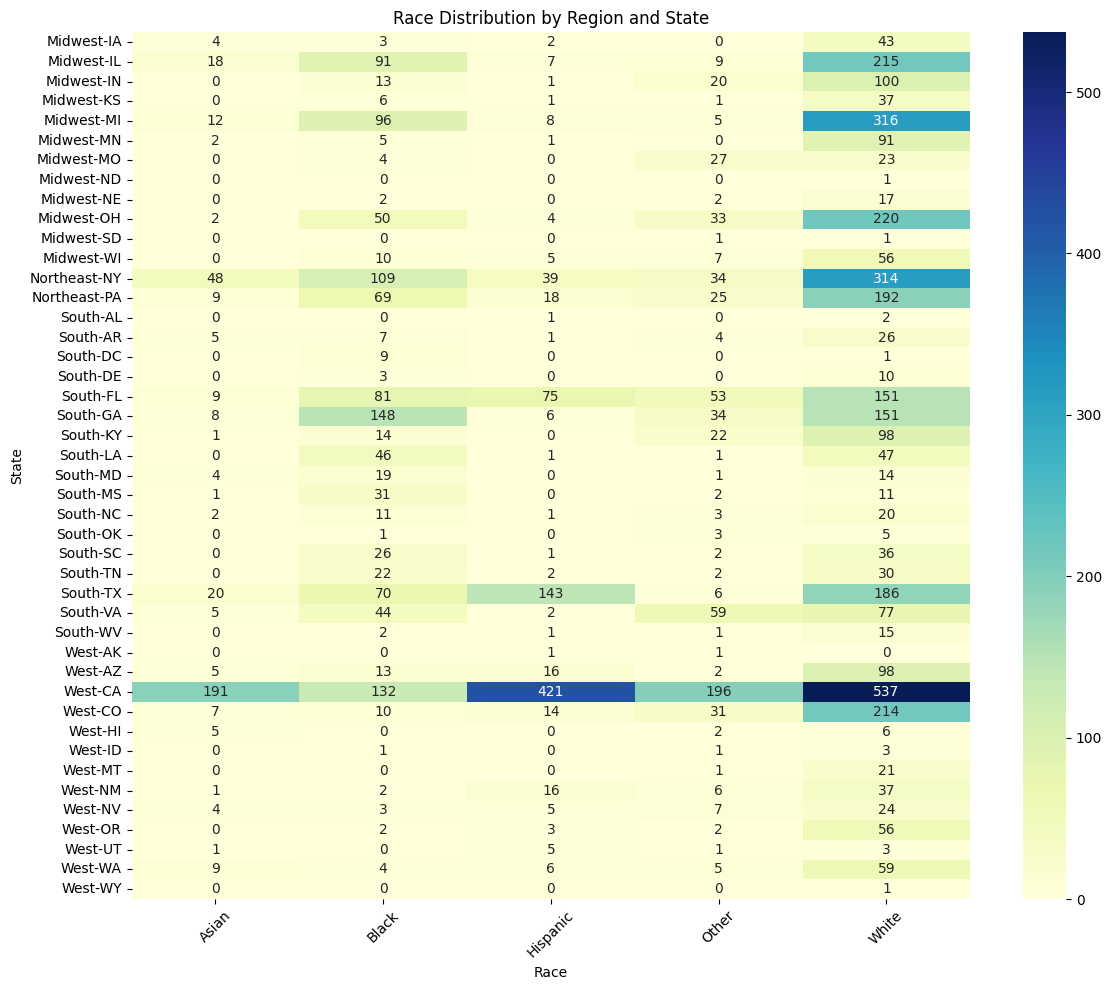

In [ ]:
# Drop rows where patient_race, Region, or patient_state is null
filtered_data = filtered_train.dropna(subset=['patient_race', 'Region', 'patient_state'])

# Aggregate Race Counts by Region and State
race_region_state_counts = filtered_data.groupby(['Region', 'patient_state', 'patient_race']).size().unstack(fill_value=0)

# Step 4: Create a Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(race_region_state_counts, cmap='YlGnBu', annot=True, fmt='d', cbar=True)
plt.title('Race Distribution by Region and State')
plt.xlabel('Race')
plt.ylabel('State')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-37-b7fd20b42908>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='patient_race', y='metastatic_diagnosis_period', data=filtered_train, palette='viridis')


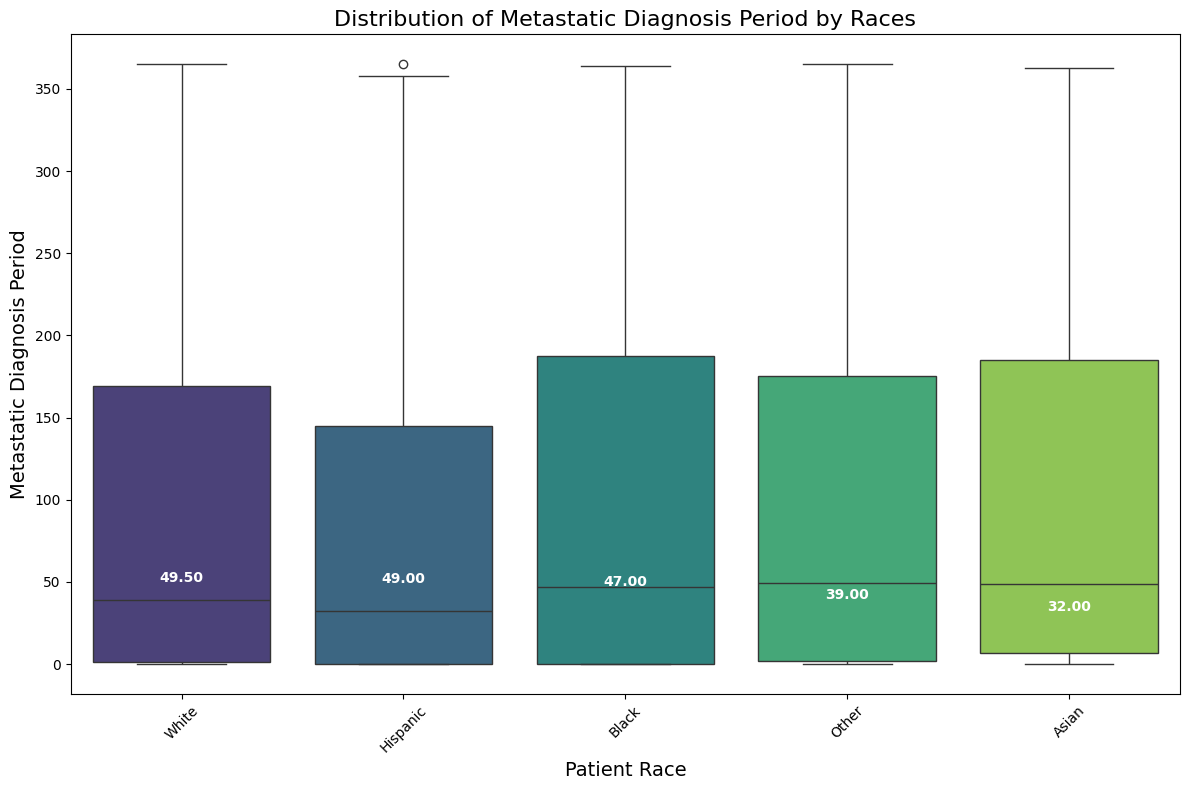

In [ ]:
# Create box plot using seaborn
plt.figure(figsize=(12, 8))
sns.boxplot(x='patient_race', y='metastatic_diagnosis_period', data=filtered_train, palette='viridis')

# Calculate and annotate with median values
medians = filtered_train.groupby('patient_race')['metastatic_diagnosis_period'].median().sort_values(ascending=False)
median_labels = [f'{med:.2f}' for med in medians]

# Add annotations for medians
for tick, label in zip(range(len(medians)), plt.gca().get_xticklabels()):
    plt.text(tick, medians[tick] + 0.5, median_labels[tick],
             horizontalalignment='center', size='medium', color='white', weight='semibold')

# Set plot title and labels
plt.title('Distribution of Metastatic Diagnosis Period by Races', fontsize=16)
plt.xlabel('Patient Race', fontsize=14)
plt.ylabel('Metastatic Diagnosis Period', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 55.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 32.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 22.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 16.4% of the points cannot be plac

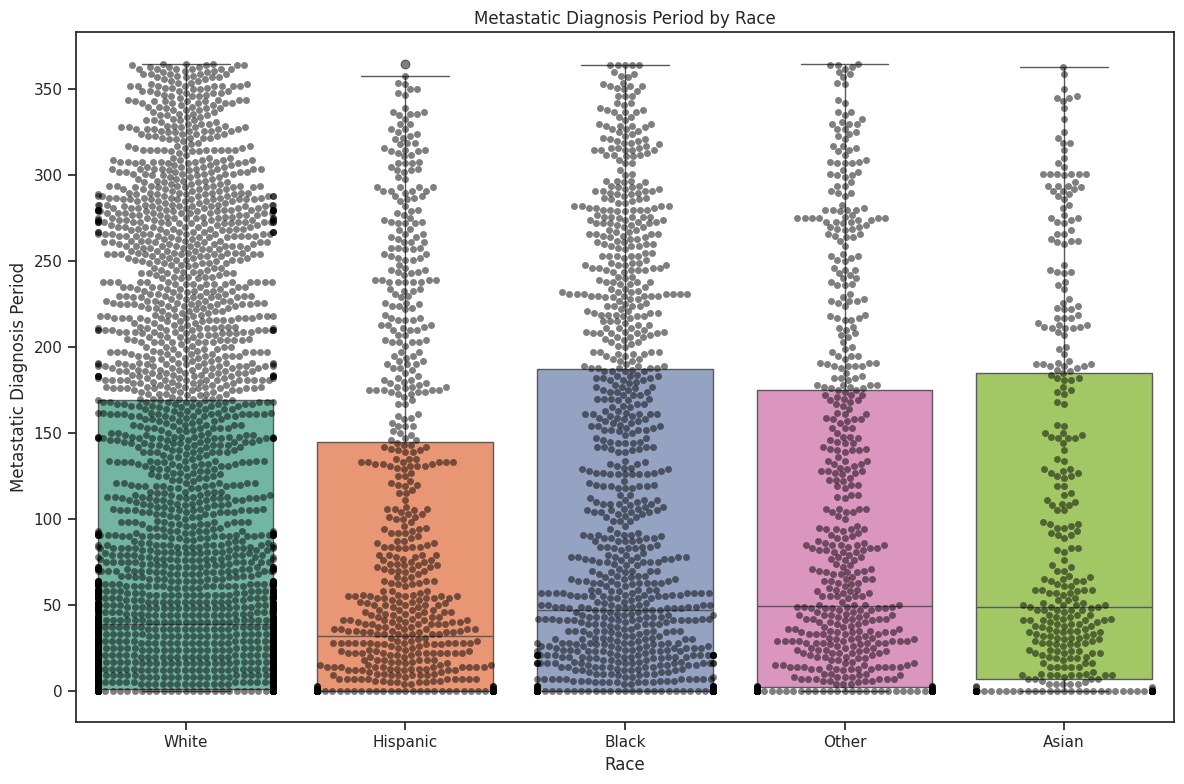

In [ ]:
plt.figure(figsize=(12, 8))
sns.swarmplot(data=filtered_train, x='patient_race', y='metastatic_diagnosis_period', color='black', alpha=0.5)
sns.boxplot(data=filtered_train, x='patient_race', y='metastatic_diagnosis_period', palette='Set2')
plt.title('Metastatic Diagnosis Period by Race')
plt.xlabel('Race')
plt.ylabel('Metastatic Diagnosis Period')
plt.tight_layout()
plt.show()


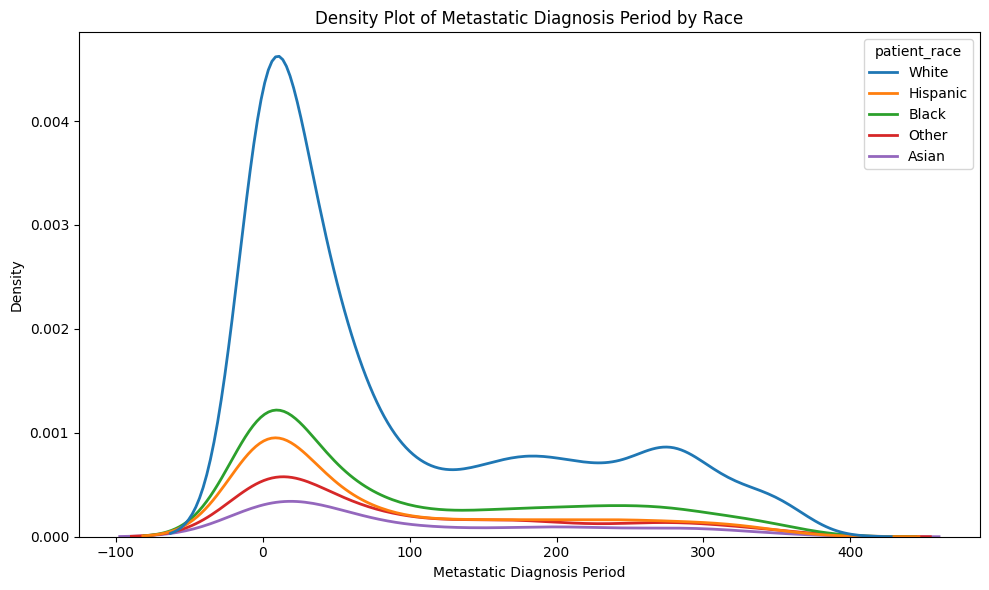

In [ ]:
# Select relevant columns for the density plot by race
density_data = filtered_train[['metastatic_diagnosis_period', 'patient_race']]

# Initialize a figure with a specific size
plt.figure(figsize=(10, 6))

# Plot density of metastatic_diagnosis_period by Region without fill
sns.kdeplot(data=density_data, x='metastatic_diagnosis_period', hue='patient_race', fill=False, linewidth=2)
plt.title('Density Plot of Metastatic Diagnosis Period by Race')
plt.xlabel('Metastatic Diagnosis Period')
plt.ylabel('Density')

# Adjust layout
plt.tight_layout()
plt.show()


## **Socioeconomic Indicators**

### How can we explore the relationships among socioeconomic indicators?


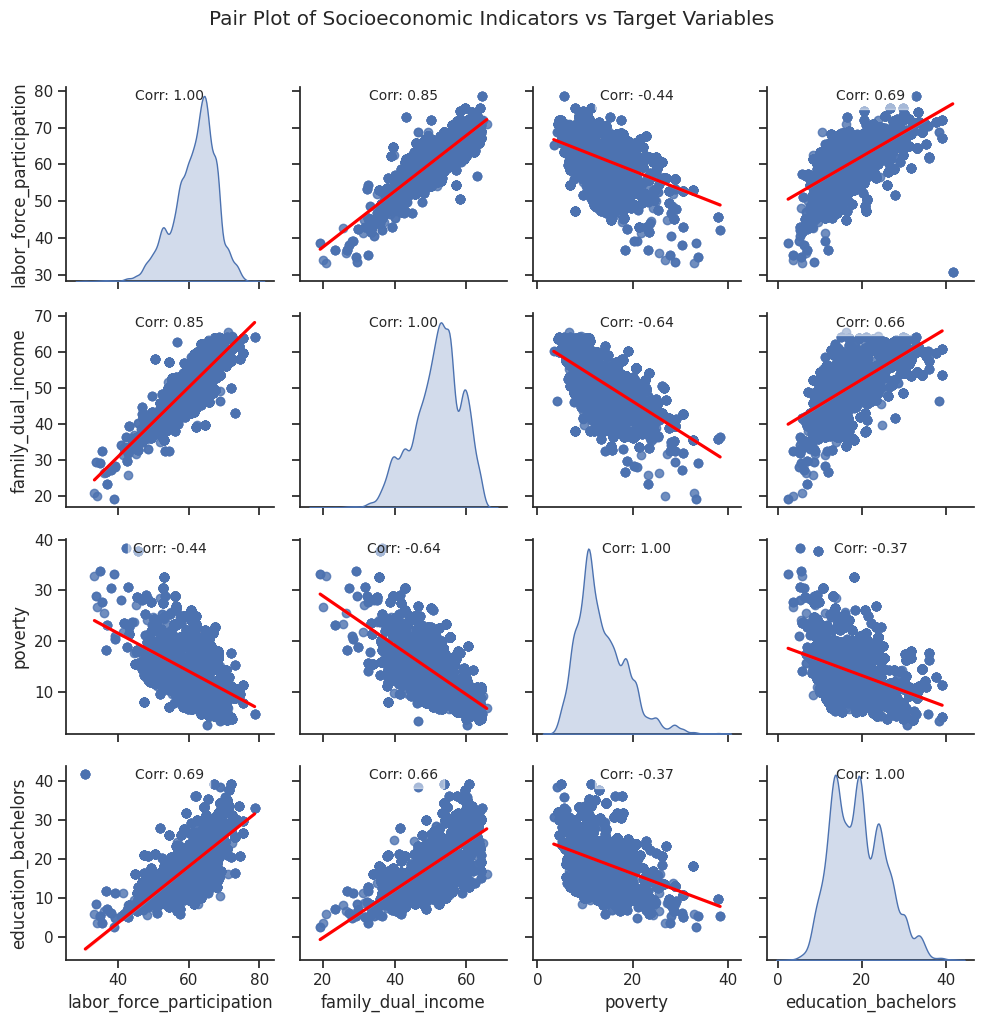

In [ ]:
# Select relevant columns for the pair plot
pairplot_data = filtered_train[['labor_force_participation', 'family_dual_income', 'poverty',
                                'education_bachelors']]

# Create pair plot with scatter plots, regression lines, and correlation coefficients
sns.set(style="ticks", color_codes=True)
sns.pairplot(pairplot_data, kind='reg', diag_kind='kde', plot_kws={'line_kws':{'color':'red'}}, height=2.5)

# Calculate and annotate correlation coefficients
correlation_matrix = pairplot_data.corr().values
for i, (ax, corr) in enumerate(zip(plt.gcf().axes, correlation_matrix.flatten())):
    ax.annotate(f'Corr: {corr:.2f}', (0.5, 0.95), xycoords='axes fraction', ha='center', va='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

plt.suptitle('Pair Plot of Socioeconomic Indicators vs Target Variables', y=1.02)
plt.tight_layout()
plt.show()


## **Cancer Code Analysis**

### What are the distributions of breast cancer diagnosis codes and metastatic cancer diagnosis codes in the dataset?

### What is the distribution of metastatic cancer diagnosis codes among different races in the dataset?

## What is the mean metastatic diagnosis period for different metastatic cancer diagnosis codes in the dataset?

### What is the co-occurrence pattern between breast cancer diagnosis codes and metastatic cancer diagnosis codes based on the dataset?


<ipython-input-25-c6ee64cb917b>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=filtered_train, x='breast_cancer_diagnosis_code', order=sorted_codes, palette='coolwarm')  # Change palette to 'coolwarm'


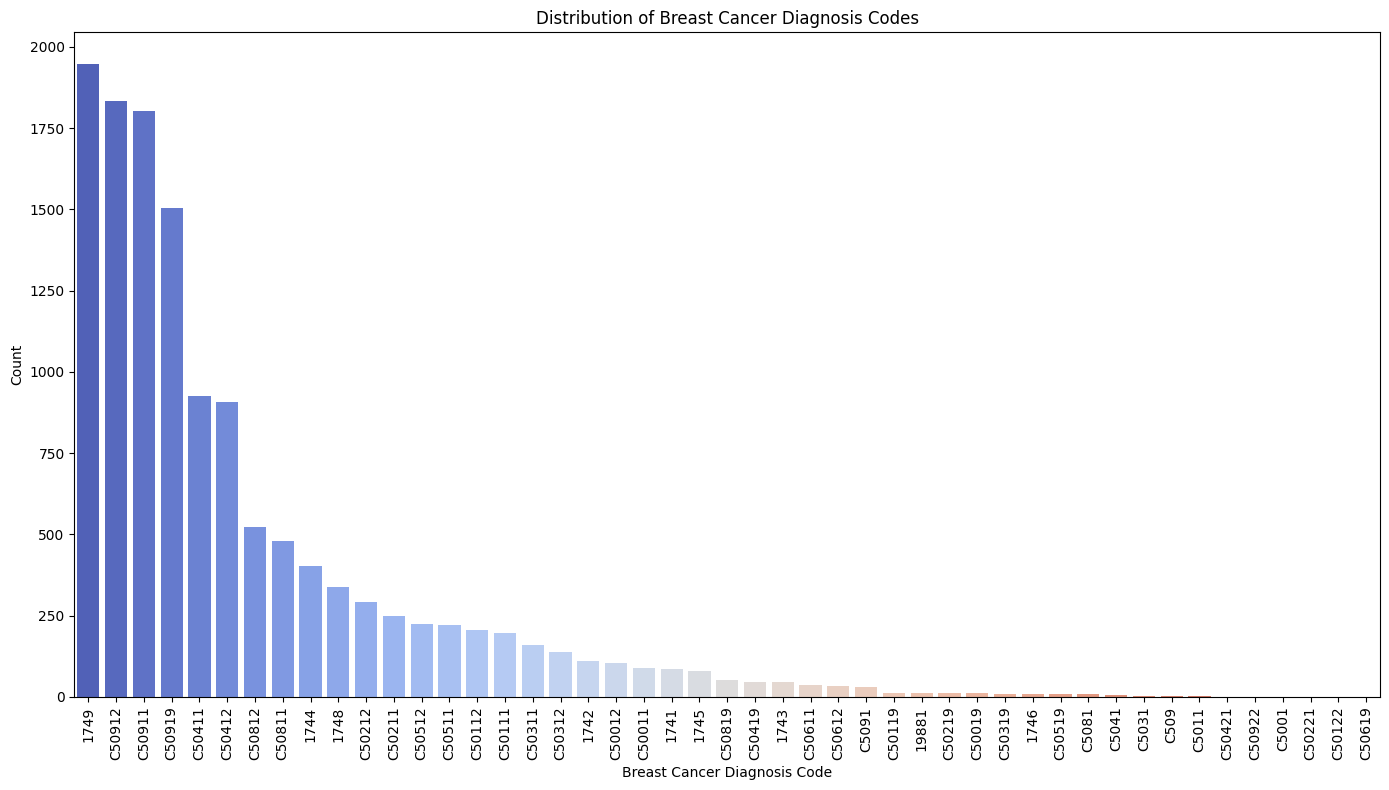

In [25]:
# Compute the counts of each diagnosis code
breast_cancer_counts = filtered_train['breast_cancer_diagnosis_code'].value_counts()

# Sort the diagnosis codes by count
sorted_codes = breast_cancer_counts.index

plt.figure(figsize=(14, 8))
sns.countplot(data=filtered_train, x='breast_cancer_diagnosis_code', order=sorted_codes, palette='coolwarm')  # Change palette to 'coolwarm'
plt.title('Distribution of Breast Cancer Diagnosis Codes')
plt.xlabel('Breast Cancer Diagnosis Code')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


<ipython-input-24-7f21529ad191>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=filtered_train, x='metastatic_cancer_diagnosis_code', order=sorted_codes, palette='coolwarm')  # Change palette to 'coolwarm'


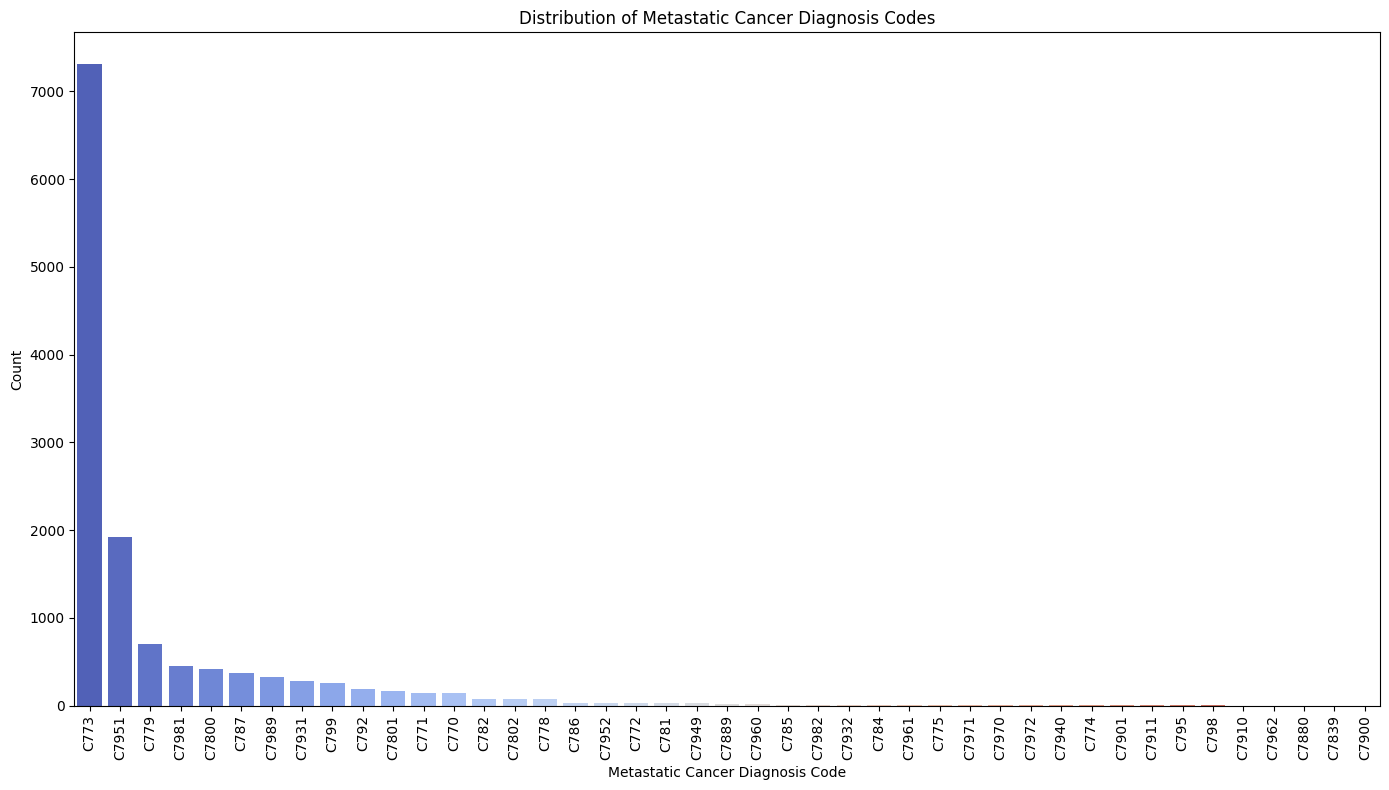

In [24]:
# Compute the counts of each diagnosis code
breast_cancer_counts = filtered_train['metastatic_cancer_diagnosis_code'].value_counts()

# Sort the diagnosis codes by count
sorted_codes = breast_cancer_counts.index

plt.figure(figsize=(14, 8))
sns.countplot(data=filtered_train, x='metastatic_cancer_diagnosis_code', order=sorted_codes, palette='coolwarm')  # Change palette to 'coolwarm'
plt.title('Distribution of Metastatic Cancer Diagnosis Codes')
plt.xlabel('Metastatic Cancer Diagnosis Code')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


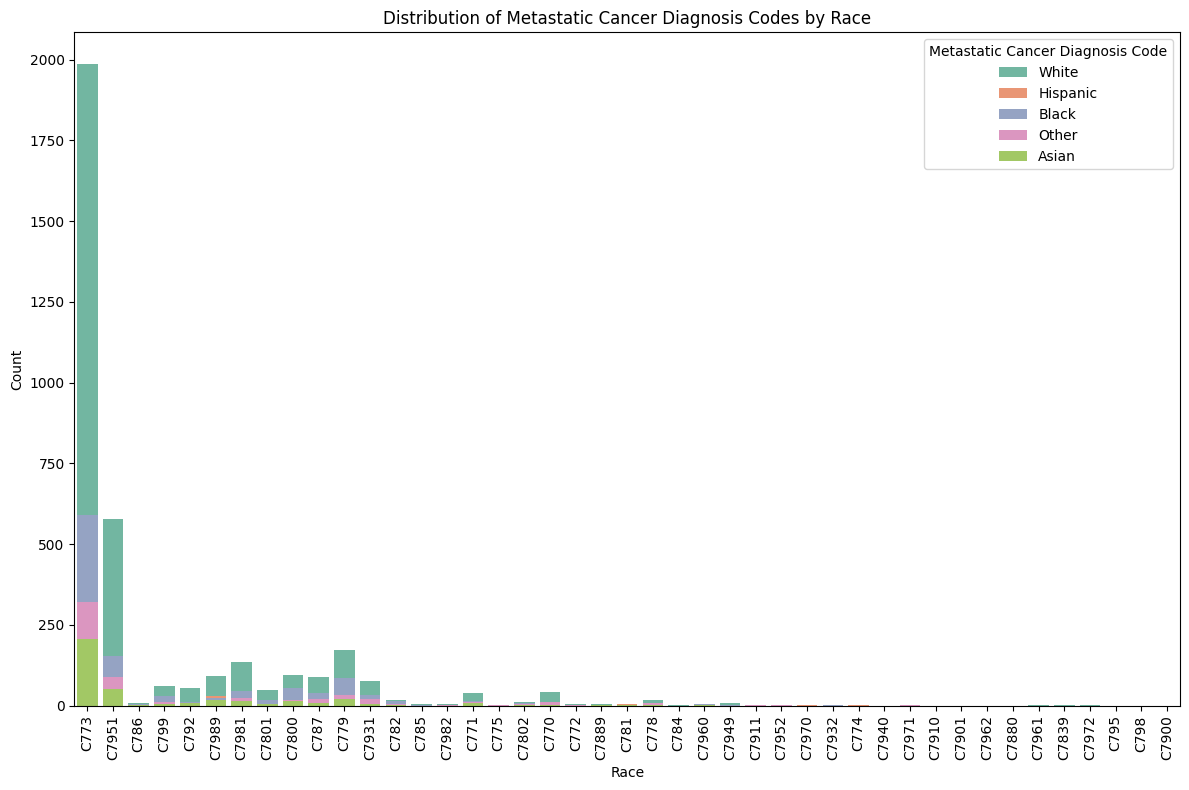

In [20]:
plt.figure(figsize=(12, 8))
sns.countplot(data=filtered_train, x='metastatic_cancer_diagnosis_code', hue='patient_race', palette='Set2', dodge=False)
plt.title('Distribution of Metastatic Cancer Diagnosis Codes by Race')
plt.xlabel('Race')
plt.ylabel('Count')
plt.legend(title='Metastatic Cancer Diagnosis Code')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

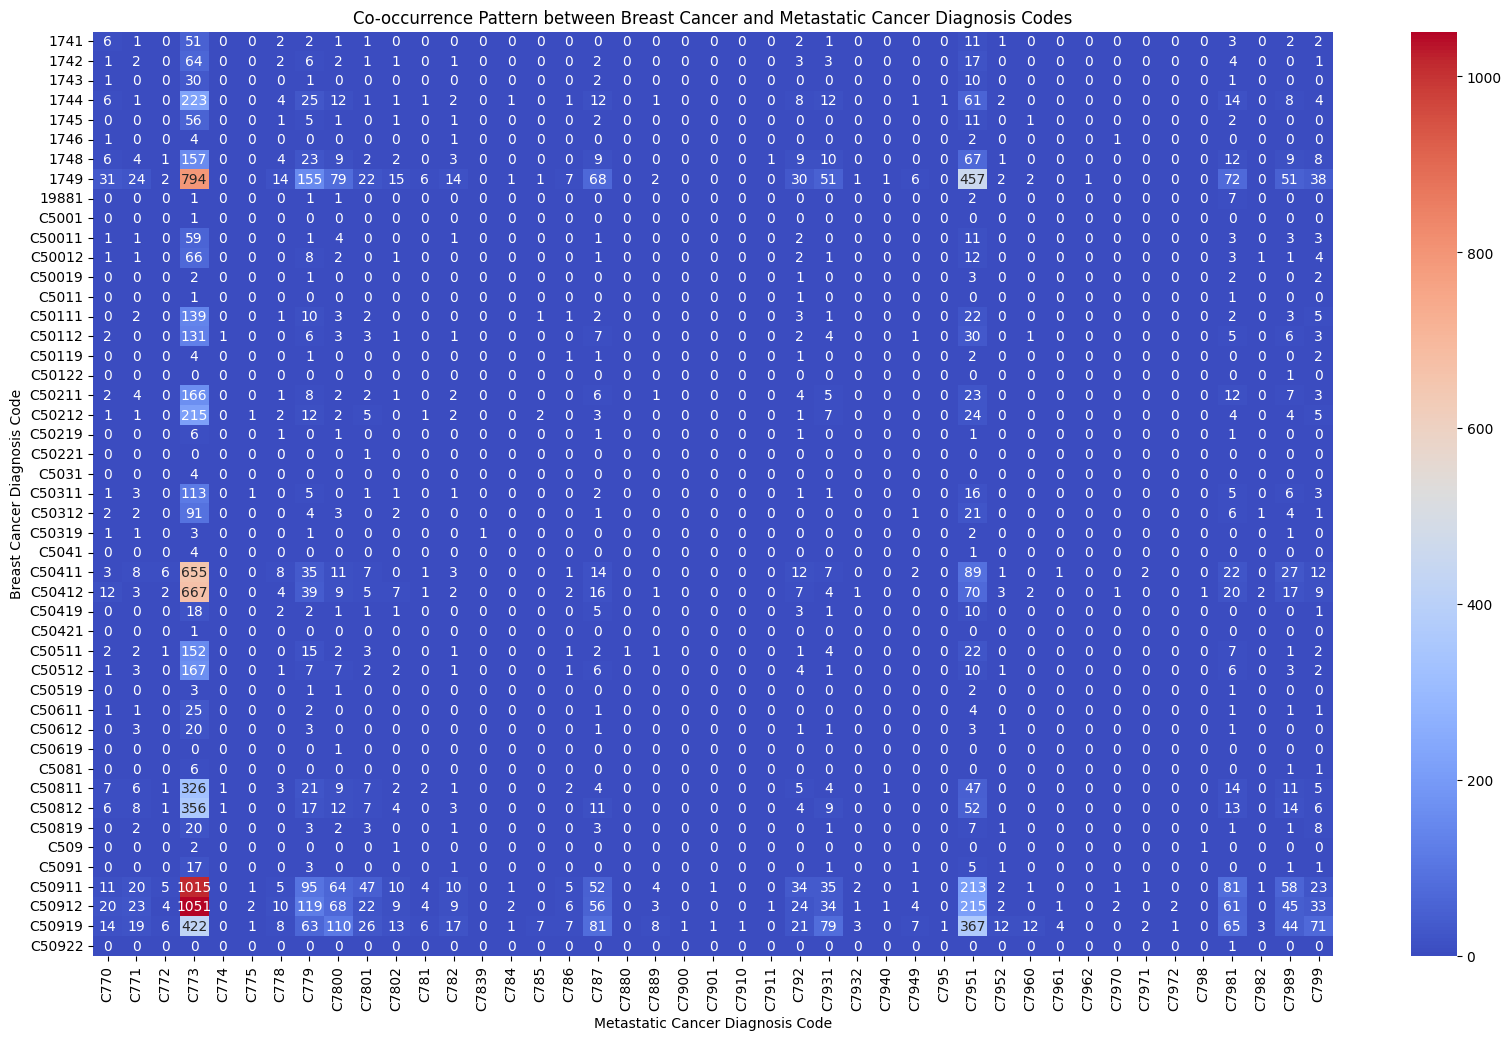

In [29]:
# Create a contingency table
co_occurrence_table = pd.crosstab(filtered_train['breast_cancer_diagnosis_code'], filtered_train['metastatic_cancer_diagnosis_code'])

# Visualize the co-occurrence matrix using a heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(co_occurrence_table, cmap='coolwarm', annot=True, fmt='d', annot_kws={"size": 10})
plt.title('Co-occurrence Pattern between Breast Cancer and Metastatic Cancer Diagnosis Codes')
plt.xlabel('Metastatic Cancer Diagnosis Code')
plt.ylabel('Breast Cancer Diagnosis Code')
plt.show()


<ipython-input-42-ba1c493c0c8c>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='metastatic_cancer_diagnosis_code', y='metastatic_diagnosis_period', data=filtered_train, order=mean_target_by_code['metastatic_cancer_diagnosis_code'], palette='viridis')


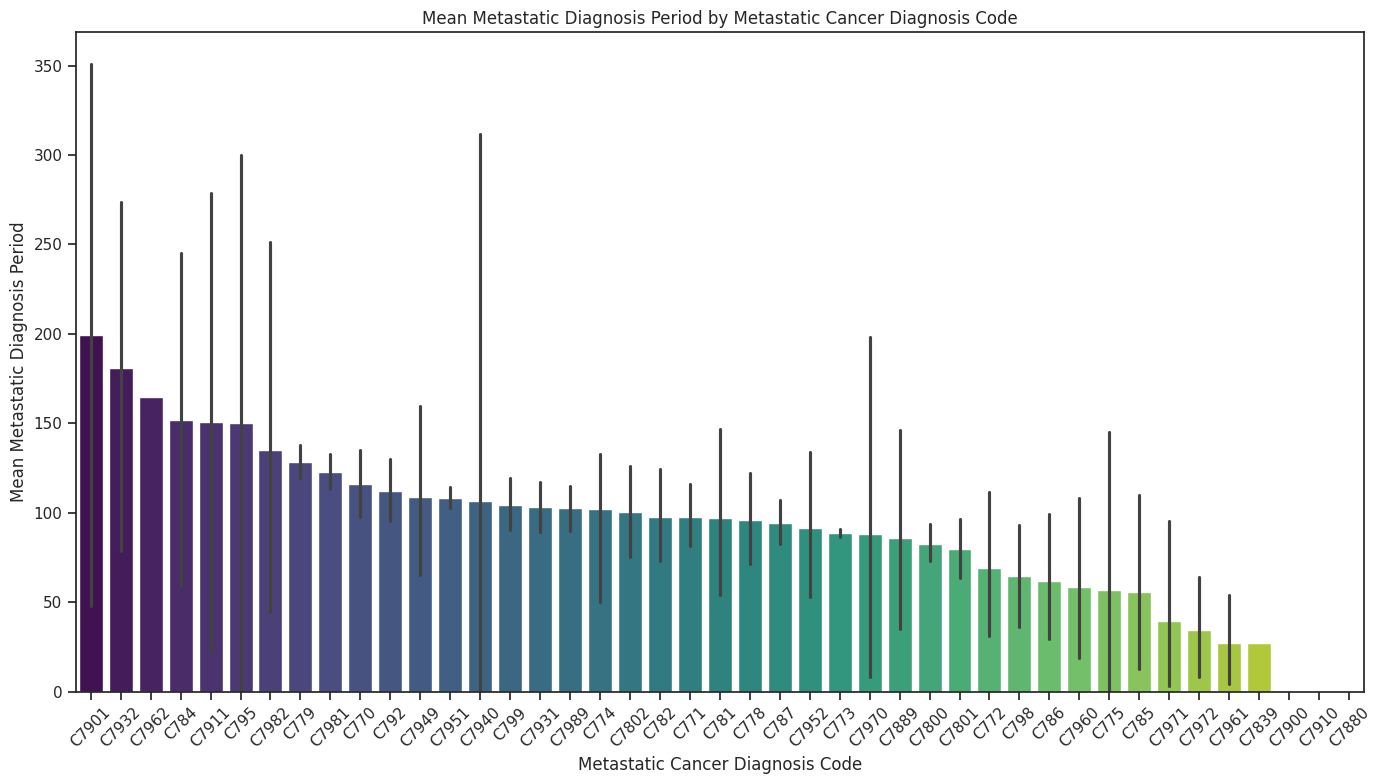

In [ ]:
# Calculate mean target for each metastatic_cancer_diagnosis_code
mean_target_by_code = filtered_train.groupby('metastatic_cancer_diagnosis_code')['metastatic_diagnosis_period'].mean().reset_index()

# Sort by mean metastatic_diagnosis_period from highest to lowest
mean_target_by_code = mean_target_by_code.sort_values(by='metastatic_diagnosis_period', ascending=False)

# Create the bar plot
plt.figure(figsize=(14, 8))
sns.barplot(x='metastatic_cancer_diagnosis_code', y='metastatic_diagnosis_period', data=filtered_train, order=mean_target_by_code['metastatic_cancer_diagnosis_code'], palette='viridis')
plt.title('Mean Metastatic Diagnosis Period by Metastatic Cancer Diagnosis Code')
plt.xlabel('Metastatic Cancer Diagnosis Code')
plt.ylabel('Mean Metastatic Diagnosis Period')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



## **Applying NLP to breast_cancer_diagnosis_desc Column**

In [ ]:
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:

# Text preprocessing function
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Apply text preprocessing
filtered_train['breast_cancer_diagnosis_desc'] = filtered_train['breast_cancer_diagnosis_desc'].apply(preprocess_text)

# Replace abbreviations with full form
filtered_train['breast_cancer_diagnosis_desc'] = filtered_train['breast_cancer_diagnosis_desc'].replace({
    r'\bmalig\b': 'malignant',
    r'\bunsp\b': 'unspecified',
    r'\bovrlp\b': 'overlapping',
    r'\bneoplm\b': 'neoplasm'
}, regex=True)

<ipython-input-124-eacd456d5c77>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_train['breast_cancer_diagnosis_desc'] = filtered_train['breast_cancer_diagnosis_desc'].apply(preprocess_text)
<ipython-input-124-eacd456d5c77>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_train['breast_cancer_diagnosis_desc'] = filtered_train['breast_cancer_diagnosis_desc'].replace({


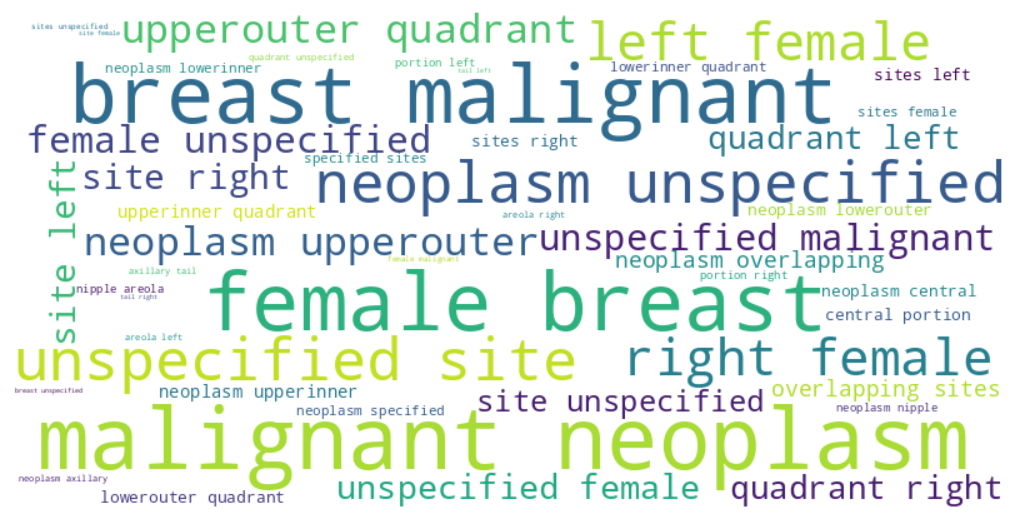

In [ ]:
# Function to generate word cloud
def generate_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

# Join all preprocessed text into a single string for word cloud generation
all_text = ' '.join(filtered_train['breast_cancer_diagnosis_desc'].values)

# Generate and display the word cloud
generate_wordcloud(all_text)
